# COVID 이후 행정구역 특성에 따른 소비패턴의 변화를 알아보자!

## **00. 분석 개요**

![](캡처.PNG)
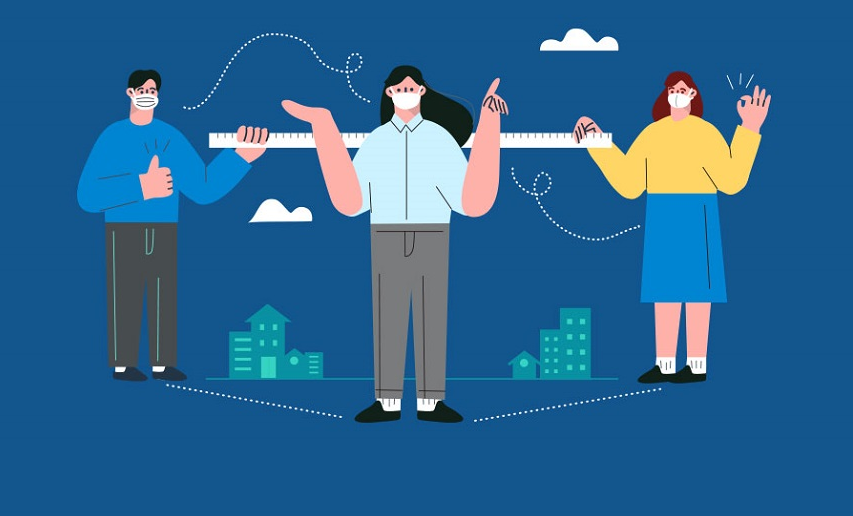

- '사회적 거리두기'가 지속되고, 사람들이 집에 머무는 시간이 늘어나면서 변화된 소비 패턴을 분석하는 것은 여러 기업들의 중요한 과제가 되었습니다. 
- "만약 진정으로 사람들이 '주로 집에서 머물기 때문에' 어떤 품목에서 소비 패턴이 변화하였다면, 해당 품목은 분명 업무 중심 지역에서보다 주거 중심 지역에서 두드러지는 변화를 보일 것이다." 이러한 가정을 바탕으로 저희는 다음의 분석을 진행하였습니다.

<br>

- 먼저 서울을 '주거 중심 지역'과 '업무 중심 지역'으로 나눈 후, 각 지역에서 소비 패턴이 어떻게 변화하였는지를 살펴보았습니다. 특정한 기준을 바탕으로 서울 내의 구를 grouping한 후 코로나 확진자 수 증가에 따른 소비 추이를 시각화해본 결과는 다음과 같았습니다.
  - 성장한 업종
    - 업무 중심 지역 : 사무용품, 전자상거래, 소프트웨어 관련 산업 성장
    - 주거 중심 지역 : 가전제품, 부엌용품, 교육, 화장품 관련 산업 성장
  - 감소한 업종
    - 공통적으로 노래방, 식당, 레저산업, 미용 산업이 감소
- 이때 저희는 미용원 매출이 확진자수가 증가함에 따라 감소한 한편, 주거 지역에서 화장품 업종의 매출은 오히려 증가하였음을 확인하고 이를 바탕으로 소비 품목 지수 데이터(index)를 살펴보았습니다.
- 그 결과, 흥미롭게도 뷰티소품, 화장품 품목의 경우 업무 지역보다 주거 지역에서 더 높은 카테고리 성장 지수를 보임을 발견하였습니다. <br>
즉 코로나로 인해 사람들은 밖으로 나가 타인과 대면하여 케어 서비스를 받기보다 스스로를 관리하는 '**셀프 케어**'에 관심을 갖기 시작한 것입니다. 이러한 분석을 통해 포스트 코로나 시대에 '셀프 케어'는 성장하는 산업의 중요한 키워드 중 하나가 될 것임을 예측해볼 수 있습니다.

<br>

### 분석 환경
- 구글 Colaboratory에서 Jupyter notebook으로 작업

- 구글 드라이브에서 Colab으로 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


- Change working directory

In [ ]:
cd drive/My Drive/KT

/content/drive/.shortcut-targets-by-id/1ORqNrXIgviF6I_o-Jip6czbYieSHcYlP/KT


In [ ]:
%matplotlib inline  
import pandas as pd # 데이터 프레임 관리
import numpy as np # 배열 생성 및 설정
import matplotlib as mpl  # 시각화 기본 설정 용도
import matplotlib.font_manager as fm  # matplotlib 폰트 관련 용도
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### matplotlib 한글 폰트 설치 및 설정

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 '나눔바른고딕' 사용
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
fm._rebuild()
plt.rc('font', family=font_name)

## **01. 데이터 준비**

#### 데이터 로드
- 유동인구 데이터
- 카드 데이터
- 행정동 데이터
- 코로나 확진 현황 데이터
- cgi 데이터

In [ ]:
fpop = pd.read_csv('fpopl.csv') # 유동인구 데이터(서울)
card = pd.read_csv('card_20200717.csv') # 카드 데이터(서울)
astrd_master = pd.read_csv('adstrd_master.csv') # 행정동 데이터(전국)
corona = pd.read_csv('./COVID_19/PatientInfo_20200717.csv', sep = '\t', error_bad_lines=False, engine= 'python', encoding='cp949') # 코로나 감염 현황(전국)
index = pd.read_csv('index.csv') # 품목별 cgi(서울)

#### 단순 데이터 전처리
- 코로나 확진 현황, 행정동 데이터를 제외하고 다른 데이터들은 **Only Seoul** -> 분석 대상을 **서울 지역**으로 한정

In [ ]:
seoul_corona = corona.query("province == '서울'").reset_index().iloc[:,1:]
astrd_master = astrd_master.query("brtc_nm == '서울특별시'").reset_index().iloc[:,1:]

- card 데이터의 행정동 코드와 행정동 데이터의 시군구 이름을 매칭시키기 위해 통일시키는 작업

In [ ]:
astrd_master['adstrd_code'] = astrd_master['adstrd_code'].astype(int).astype(str)
astrd_master['sigungu_code'] = astrd_master['adstrd_code'].str[:4]
astrd_master['sigungu'] = astrd_master['sigungu_code'].astype(int)

- PatientInfo 데이터 셋 city 컬럼에 **동구 구** -> 동작구 (강한 추정)

In [ ]:
tem_city = seoul_corona['city'].replace('동구 구', '동작구')
seoul_corona['city'] = tem_city

## **02. 탐색적 분석**

#### 유동인구 데이터
- 시기: 2020-01-01 ~ 2020-06-16
- **Dimension**
  - base_ymd        : 기준연월일
  - tmzon_se_code   : 24시간대 구분코드
  - sexdstn_se_code : 성별 구분코드 (M:남성, F:여성)
  - argde_se_code   : 5세단위 연령대 구분코드
  - astrd_code      : 행정동코드
- **Value**
  - popltn_cascnt   : 유동인구 수

- 디멘젼 컬럼이 값보다 훨씬 많기 때문에, EDA를 위해 그룹핑하여 볼 필요가 있습니다. 그래서 **성별, 연령** 기준으로 그룹핑을 하기로 했습니다.
- 그리고 유동 인구의 행정동 구분이 동 단위로 되어 있는데, 전체적인 구획의 특징을 보기 위해 **구 단위**로 그룹핑했습니다.

In [ ]:
fpop['base_ymd'] = fpop['base_ymd'].astype(str)
# fpop['sigungu'] = fpop['adstrd_code'].astype(str).str[:4]

##### 기준 월로 슬라이스
- 파일 크기가 너무 커서 그룹핑할 때, 메모리 과부하 현상이 일어나 세션이 계속 초기화되는 현상이 있었습니다.
- 그래서 기준 월로 데이터 프레임을 나눠 그룹핑한 뒤, 다시 합치는 작업을 했습니다.

In [ ]:
fpop['base_m'] = fpop['base_ymd'].astype(str).str[5]
tem_list = fpop['base_m'].to_list()
boundary = list()
N = len(tem_list)
for k in range(N-1):
  if tem_list[k] != tem_list[k+1]:
    boundary.append(k)
    continue
fpop = fpop.drop('base_m', axis = 1)

In [ ]:
tem_pd1 = fpop.iloc[:boundary[0]+1, :]
tem_pd2 = fpop.iloc[boundary[0]+1:boundary[1]+1, :]
tem_pd3 = fpop.iloc[boundary[1]+1:boundary[2]+1, :]
tem_pd4 = fpop.iloc[boundary[2]+1:boundary[3]+1, :]
tem_pd5 = fpop.iloc[boundary[3]+1:boundary[4]+1, :]
tem_pd6 = fpop.iloc[boundary[4]+1:, :]

##### 연령 기준으로 pivoting

In [ ]:
df_list = [tem_pd1, tem_pd2, tem_pd3, tem_pd4, tem_pd5, tem_pd6]
for k in range(len(df_list)):
  if k == 0:
    pivot_sex_fpop = df_list[k].pivot_table(index=['base_ymd', 'sigungu', 'sexdstn_se_code'], columns = 'agrde_se_code', 
                                  values='popltn_cascnt', aggfunc= 'sum')
    pivot_sex_fpop = pd.DataFrame(pivot_sex_fpop.to_records())
  else:
    tem_pivot_fpop = df_list[k].pivot_table(index=['base_ymd', 'sigungu', 'sexdstn_se_code'], columns = 'agrde_se_code', 
                                    values='popltn_cascnt', aggfunc= 'sum')
    tem_pivot_fpop = pd.DataFrame(tem_pivot_fpop.to_records())
    pivot_sex_fpop = pd.concat((pivot_sex_fpop, tem_pivot_fpop), axis = 0)
pivot_sex_fpop = pivot_sex_fpop.reset_index().iloc[:,1:]

- **Dimension** : base_ymd(기준연월일), sigungu(구), sexdstn_se_code(성별)
- **Value**     : popltn_cascnt(유동인구)

In [ ]:
pivot_sex_fpop.head(5)

,base_ymd,sigungu,sexdstn_se_code,age_00,age_10,age_15,age_20,age_25,age_30,age_35,age_40,age_45,age_50,age_55,age_60,age_65,age_70
0,20200101,1111,F,2207,8496,24352,79914,89094,58941,51064,44184,54101,52949,51741,37755,20167,23035
1,20200101,1111,M,1744,7363,21981,63351,92546,69779,63978,54994,67454,62850,66081,54394,30564,34788
2,20200101,1114,F,2042,7224,19438,74771,95209,67465,56850,44400,49103,47742,46658,36609,18893,20073
3,20200101,1114,M,1512,6314,18648,54218,90874,76656,70297,57225,62777,58900,58876,49913,30120,28105
4,20200101,1117,F,3992,14347,35604,120100,159149,115440,97228,74562,84165,81989,74177,54820,28424,33457


In [ ]:
age_list = [
 'age_00',
 'age_10',
 'age_15',
 'age_20',
 'age_25',
 'age_30',
 'age_35',
 'age_40',
 'age_45',
 'age_50',
 'age_55',
 'age_60',
 'age_65',
 'age_70']

In [ ]:
dim = ['sigungu', 'sexdstn_se_code']
tem_df = pd.DataFrame(np.round(pivot_sex_fpop.groupby(dim)[age_list].mean(), 2).to_records())

In [ ]:
merge_sigungu = pd.merge(tem_df, astrd_master[['sigungu','signgu_nm']], how = 'left', on = 'sigungu').drop_duplicates() \
  .reset_index().iloc[:,1:]

In [ ]:
sigungu_list = list(merge_sigungu['signgu_nm'].unique())

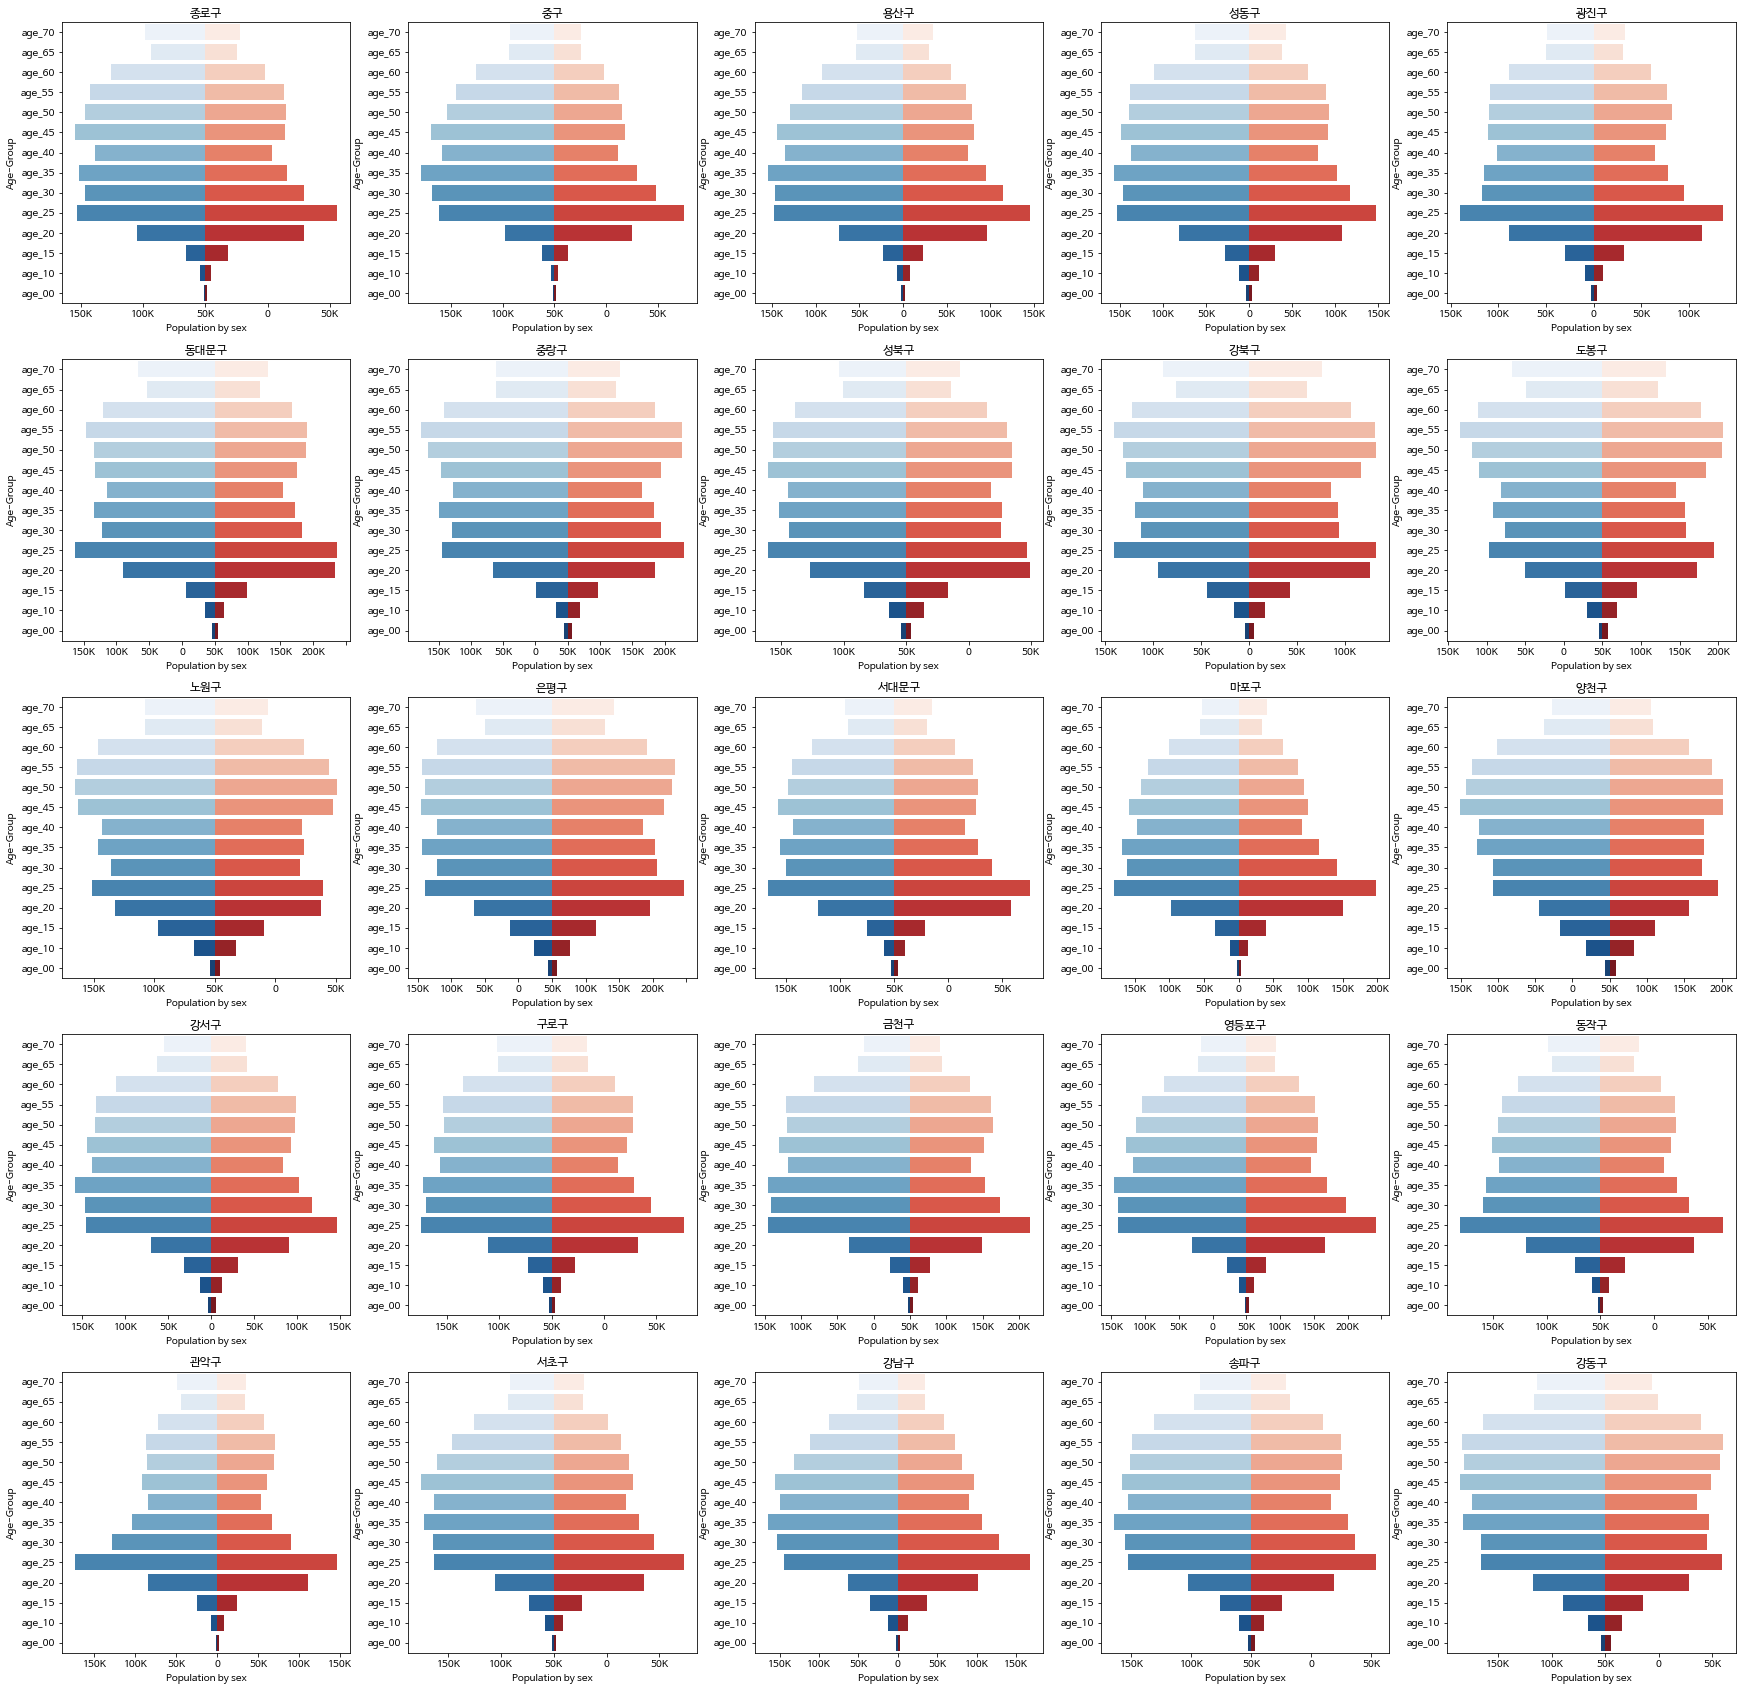

In [ ]:
ageClass = sorted(age_list, reverse = True)
fig, axes = plt.subplots(ncols=5, nrows=5, figsize = (30, 30))

for i, ax in zip(range(25), axes.flat):
  sigungu = sigungu_list[i]
  male = -1*(merge_sigungu.query(f"sexdstn_se_code == 'M' and signgu_nm == '{sigungu}'")[age_list].iloc[0])
  female = merge_sigungu.query(f"sexdstn_se_code == 'F' and signgu_nm == '{sigungu}'")[age_list].iloc[0].to_list()
  labels = ['male', 'female']
  tem_popl = pd.DataFrame({'age':age_list
                           , 'male':male
                           , 'female':female})
  bar_plot = sns.barplot(x='male', y='age', data=tem_popl, order=ageClass, orient='h', ax=ax, palette='Blues', lw=0)
  bar_plot = sns.barplot(x='female', y='age', data=tem_popl, order=ageClass, orient='h', ax=ax, palette='Reds', lw=0)
  labels = ['200K', '150K', '100K', '50K', '0', '50K', '100K', '150K', '200K']
  bar_plot.set_xticklabels(labels)
  bar_plot.set(xlabel="Population by sex", ylabel="Age-Group", title = sigungu)
plt.show()



- 연령별, 성별로 그룹핑한 뒤 유동인구의 인구 피라미드를 살펴본 결과, 구의 특징을 크게 두 가지로 나눌 수 있습니다.
- 청장년층의 유동인구가 많아 **종형을 띠는 구**(강남구, 중구, 마포구)가 있는 반면, 장년층, 노년층의 유동인구가 많아 **별 모양**(중랑구, 강동구, 노원구)을 띠는 구가 많음을 알 수 있습니다.
<br> 
`주의` : 학술지에 주로 언급되는 *거주인구*의 인구 피라미드 정의, 모양이 다름 <-> 위의 그래프는 **유동인구**의 인구 피라미드

#### 서울 코로나 확진자 데이터
- 확진 날짜: 2020-01-23 ~ 2020-06-29
- 사용할 컬럼
  - city: 행정구역
  - confirmed_date : 확진 날짜

In [ ]:
seoul_corona['base_ymd'] = seoul_corona['confirmed_date'].str[:4]+seoul_corona['confirmed_date'].str[5:7]+seoul_corona['confirmed_date'].str[8:]
seoul_corona['base_ymd'] = seoul_corona['base_ymd'].astype(int)

In [ ]:
dim = 'confirmed_date'
corona_cnt = pd.DataFrame(seoul_corona.groupby(dim)[['city']].count().to_records())

##### 서울 전체 코로나 확진자 일별 현황

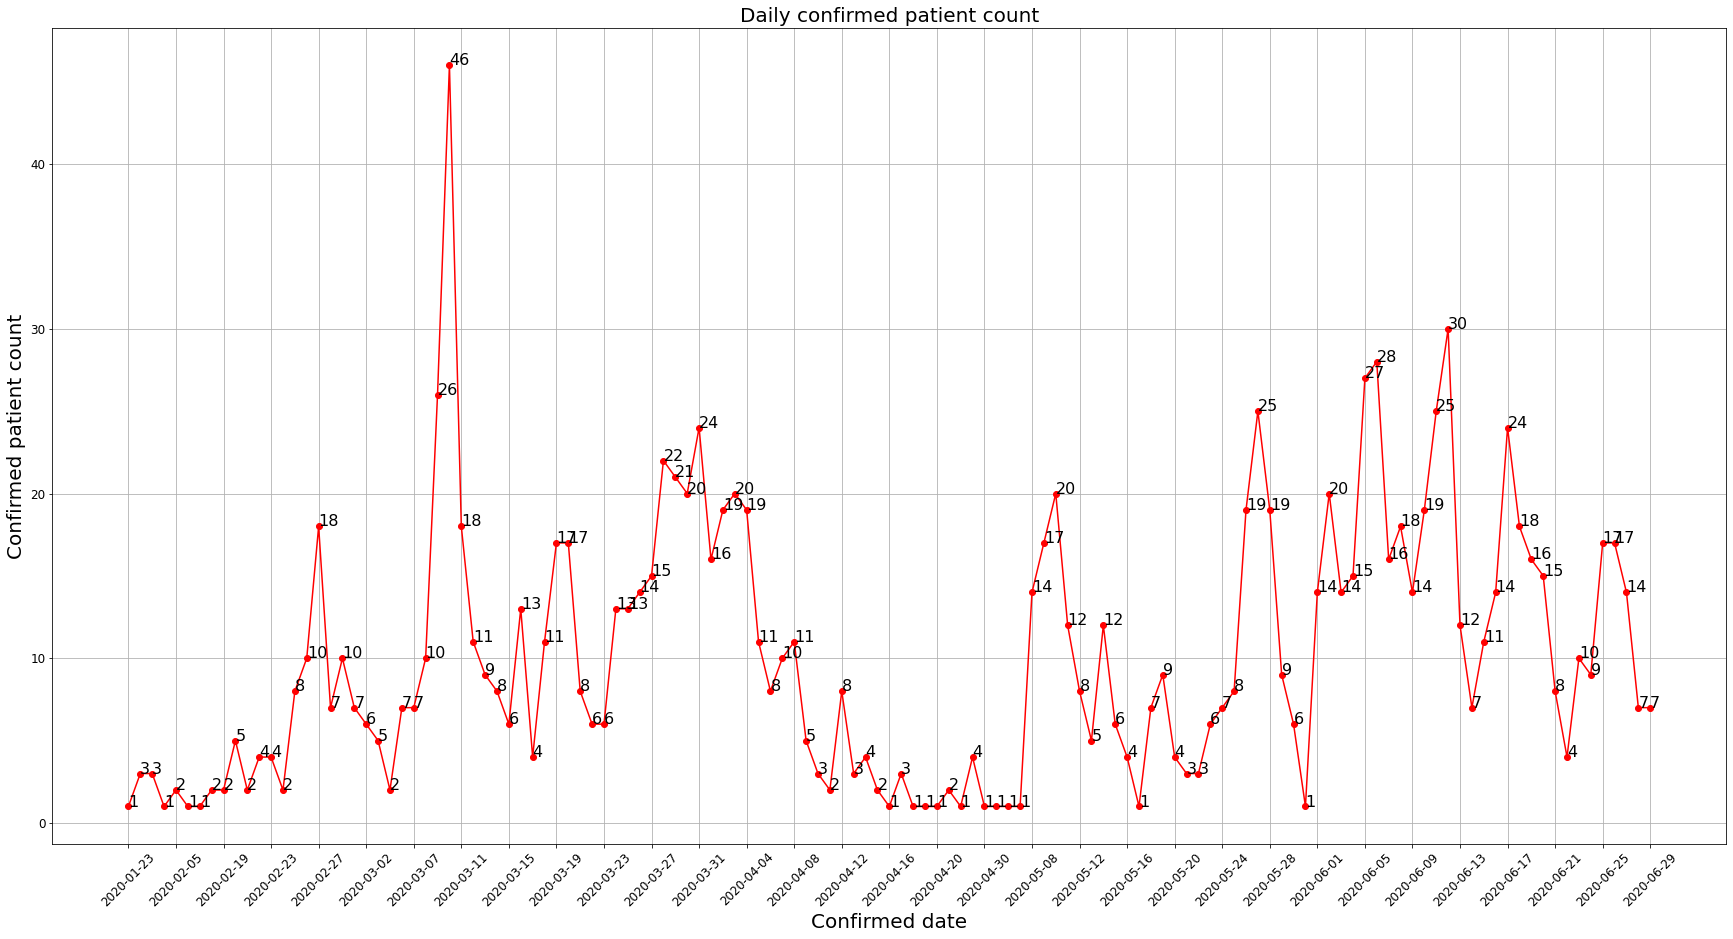

In [ ]:
tem_x = corona_cnt['confirmed_date']
tem_y = corona_cnt['city']
xn = len(tem_x)
tem_range = np.arange(xn)
tem_text = tem_y.astype(str)
plt.figure(figsize = (30,15))
plt.yticks(fontsize = 12)
plt.xticks(tem_range, tem_x[::4], rotation = 45, fontsize = 12)
plt.plot(tem_range, tem_y, 'r-', marker = 'o')
for i, txt in enumerate(tem_text):
    plt.annotate(txt, (tem_range[i], tem_y[i]), fontsize = 16)
plt.title('Daily confirmed patient count' , fontsize = 20)
plt.xlabel('Confirmed date', fontsize = 20)
plt.ylabel('Confirmed patient count', fontsize = 20)
plt.locator_params(axis='x', nbins=xn/4)
plt.grid()
plt.show()

- 서울 코로나 확진자 현황은 2/26, 3/10 급증하여 고점을 찍고, 다시 수그러들었다가 5/8 다시 급증하는 현상을 보입니다.
- 전체적으로 봤을 때 이와 같이 나타나지만, 현재 코로나 재난 알림도 구청 단위로 관리하고 있고 우리도 이에 따라 행동을 하기 때문에 **구별 현황**을 따로 확인해보기로 했습니다. 

In [ ]:
date_list = pd.date_range(start="2020-01-23",end="2020-06-29")
date_list = list(date_list.astype(str))

- 1월과 2월 비어있는 데이터 채우기

In [ ]:
signgu_date_list = [[k, date_list[x],0] for k in sigungu_list for x in range(len(date_list)) ]

In [ ]:
date_df = pd.DataFrame(np.array(signgu_date_list), columns = ['city', 'confirmed_date', 'cnt'])

In [ ]:
dim = ['confirmed_date', 'city']
signgu_corona = pd.DataFrame(seoul_corona.groupby(dim).count()[['patient_id']].to_records())

In [ ]:
date_seoul_corona = pd.merge(signgu_corona, date_df, how = 'outer', on = ['city', 'confirmed_date']).fillna(0)
date_seoul_corona['confirmed_cnt'] = date_seoul_corona['patient_id'].astype(int) + date_seoul_corona['cnt'].astype(int)

##### 서울 일별, 구별 확진자 현황
- 기타는 제외함

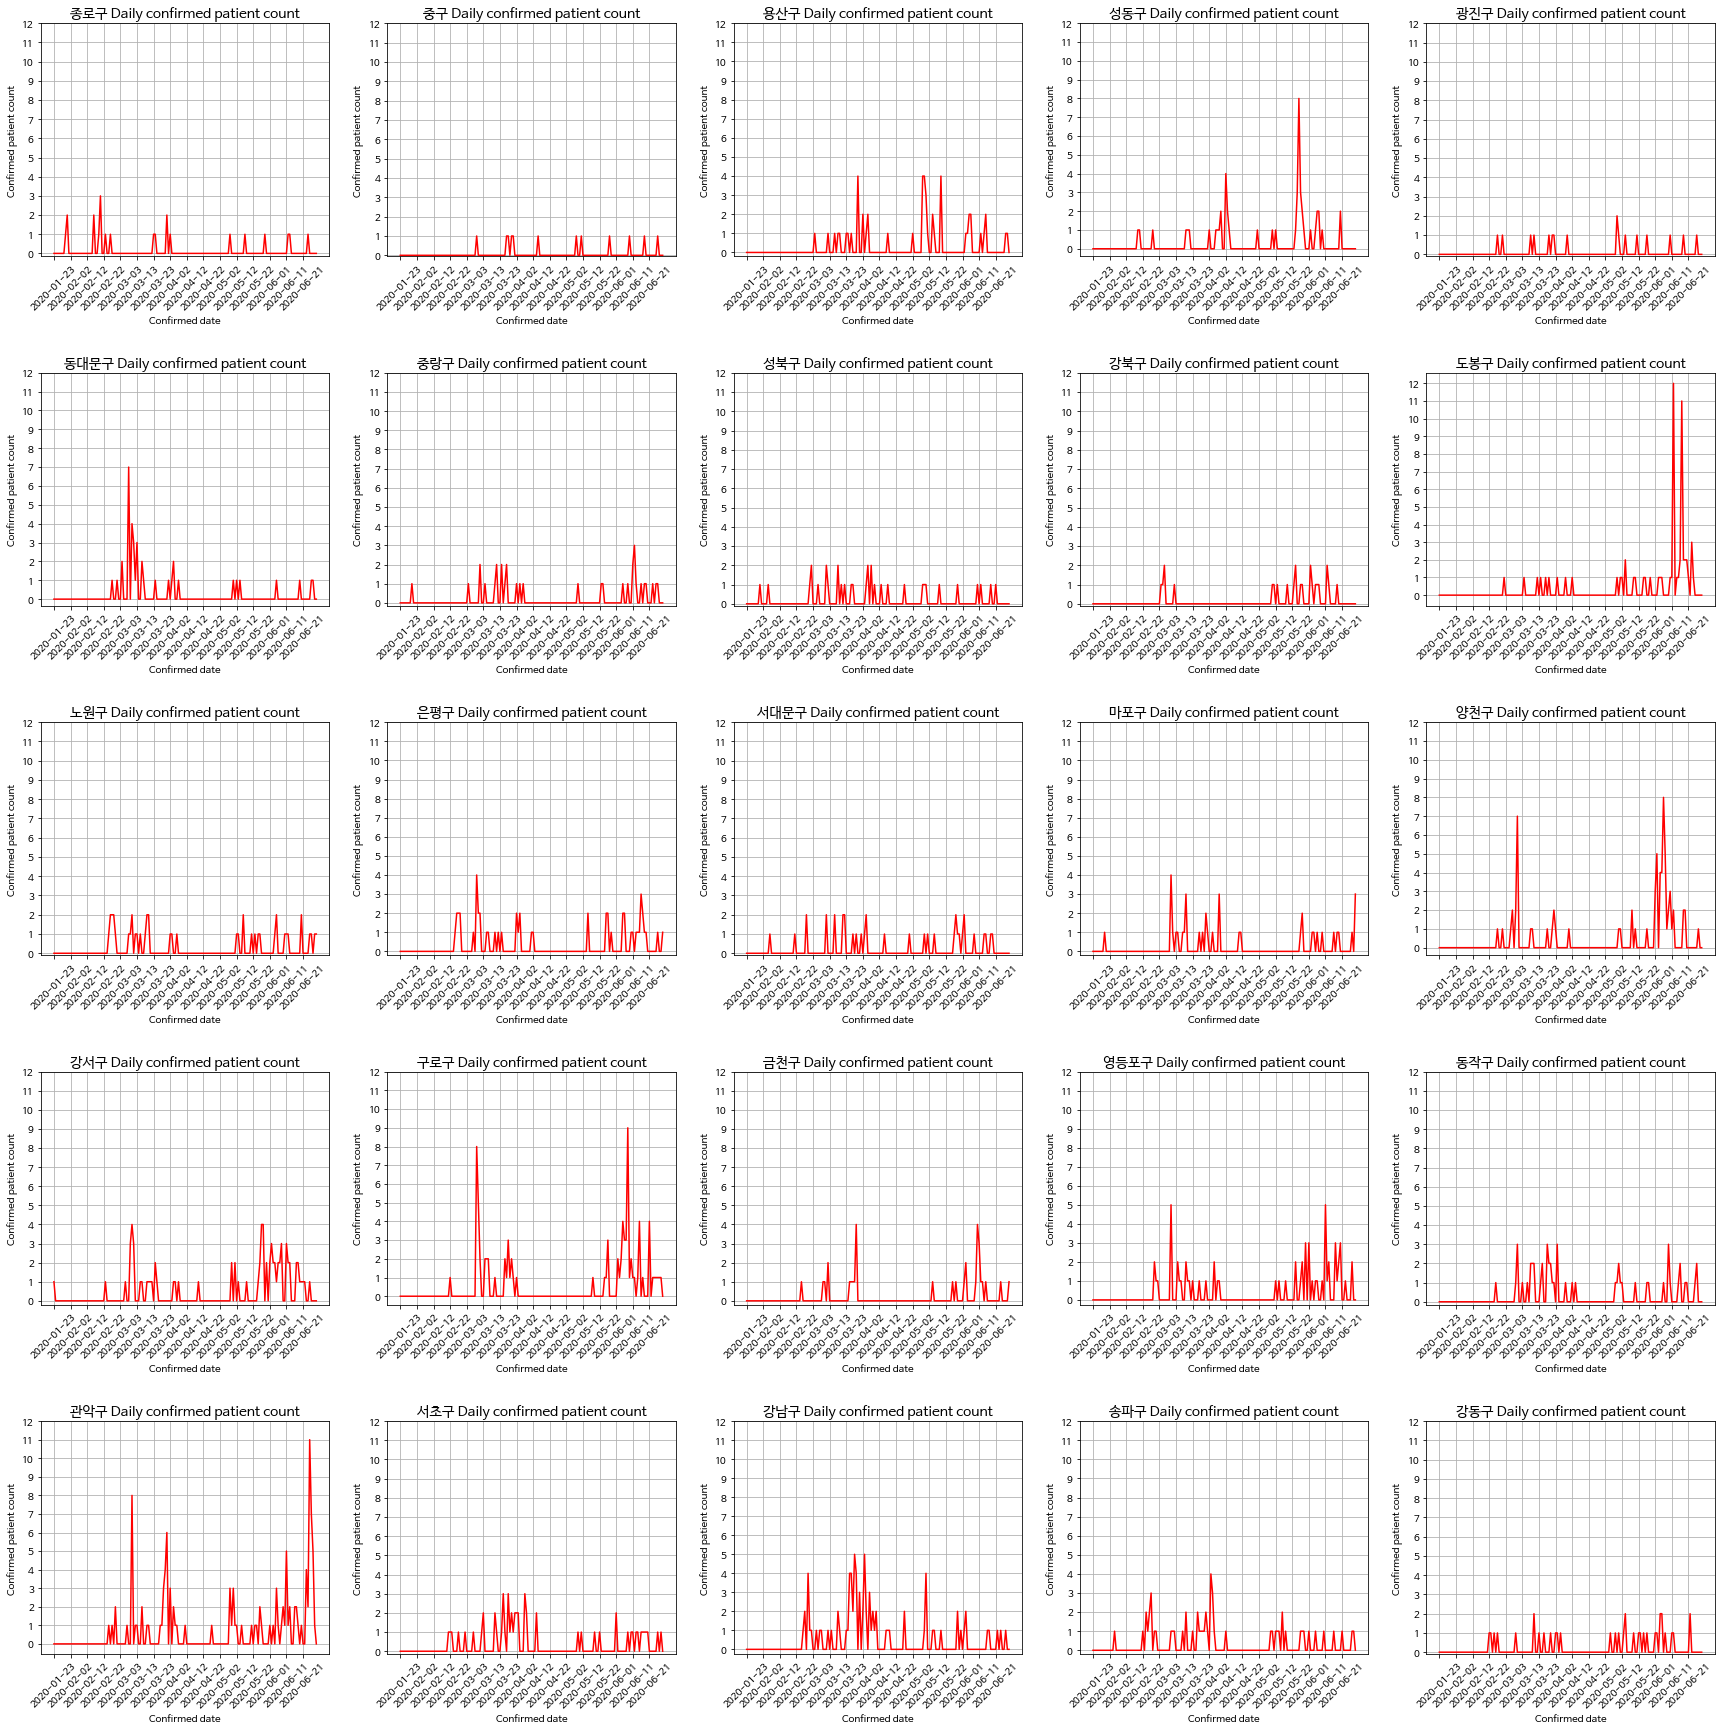

In [ ]:
fig = plt.figure(figsize=(30,30))
for n, sigungu in zip(np.arange(1,26), sigungu_list):
  a = int(round(i/5))
  b = i%5
  sigungu_df = date_seoul_corona.query(f"city == '{sigungu}'").sort_values('confirmed_date').reset_index().iloc[:,1:]
  
  tem_x = sigungu_df['confirmed_date']
  tem_y = sigungu_df['confirmed_cnt']
  xn = len(tem_x)
  tem_range = np.arange(xn)
  
  ax = fig.add_subplot(5, 5, n)
  fig.subplots_adjust(hspace = .5)
  ax.plot(tem_range, tem_y, 'r-')
  plt.yticks(np.arange(0,13), fontsize = 10)
  plt.xticks(tem_range, tem_x[::10], rotation = 45, fontsize = 10)
  plt.title('%s Daily confirmed patient count'%(sigungu) , fontsize = 14)
  plt.xlabel('Confirmed date', fontsize = 10)
  plt.ylabel('Confirmed patient count', fontsize = 10)
  plt.locator_params(axis='x', nbins=xn/10)
  plt.grid()
plt.show()

- 시기와 범위를 같게 놓고 시각화를 했을 때, 구별로 시기마다 다른 모양을 보입니다.
  - 서울 확진자의 형태와 같은 추이를 보이는 구가 있는 한편, 6월에 치솟는 구도 있습니다.
  - ex) 동대문구는 3월에 가장 높았다가 그 이후로는 잠잠해진 반면, 도봉구는 5월까지 잠잠하다가 6월에 확진자가 치솟는 추이를 보임

#### 카드 데이터의 일자별 전체 데이터
- 시기: 2020-01-04 ~ 2020-06-14
- **Dimension**
  - receipt_dttm    : 기준연월일
  - adstrd_code     : 가맹점 위치 기준 행정동 코드 -> 모두 11로 시작하고, 서울시 데이터
  - adstrd_nm               : 가맹점 위치 기준 행정동명
  - mrhst_induty_cl_code    : 가맹점 업종 코드
  - mrhst_induty_cl_nm      : 가맹점 업종명 -> 전체 260개
  
- **Value**
  - selng_cascnt            : 매출발생건수
  - salamt                  : 매출발생금액

In [ ]:
card.columns = ['base_ymd']+card.columns.to_list()[1:]

In [ ]:
card['sigungu'] = card['adstrd_code'].astype(str).str[:4].astype(int)

##### 행정구별, 직종별 매출발생건수, 총매출

In [ ]:
group_card = card.groupby(['base_ymd', 'sigungu', 'mrhst_induty_cl_nm'])[['selng_cascnt', 'salamt']].sum()
group_card = pd.DataFrame(group_card.to_records())

- 행정구 데이터 join

In [ ]:
merge_card = pd.merge(group_card, astrd_master[['signgu_nm', 'sigungu']], how = 'left', on = 'sigungu').drop_duplicates()

In [ ]:
merge_card.head(5)

,base_ymd,sigungu,mrhst_induty_cl_nm,selng_cascnt,salamt,signgu_nm
0,20200104,1111,가전 제품,46,16549561,종로구
17,20200104,1111,과학기자재,22,17912392,종로구
34,20200104,1111,관광여행,362,474818080,종로구
51,20200104,1111,귀 금 속,69,54617220,종로구
68,20200104,1111,기계 공구,96,8889982,종로구


- 직종별로 grouping
  - sales amount는 구별 평균값을 사용 -> 구 전체적인 특징을 보기 위함

In [ ]:
dim = ['base_ymd', 'mrhst_induty_cl_nm']
indstry_group_card = pd.DataFrame(merge_card.groupby(dim).mean().to_records()[dim+['salamt']])

In [ ]:
indstry_list = list(indstry_group_card['mrhst_induty_cl_nm'].unique())
indstry_group_card['ymd'] = pd.to_datetime(indstry_group_card['base_ymd'], format = '%Y%m%d').astype(str)

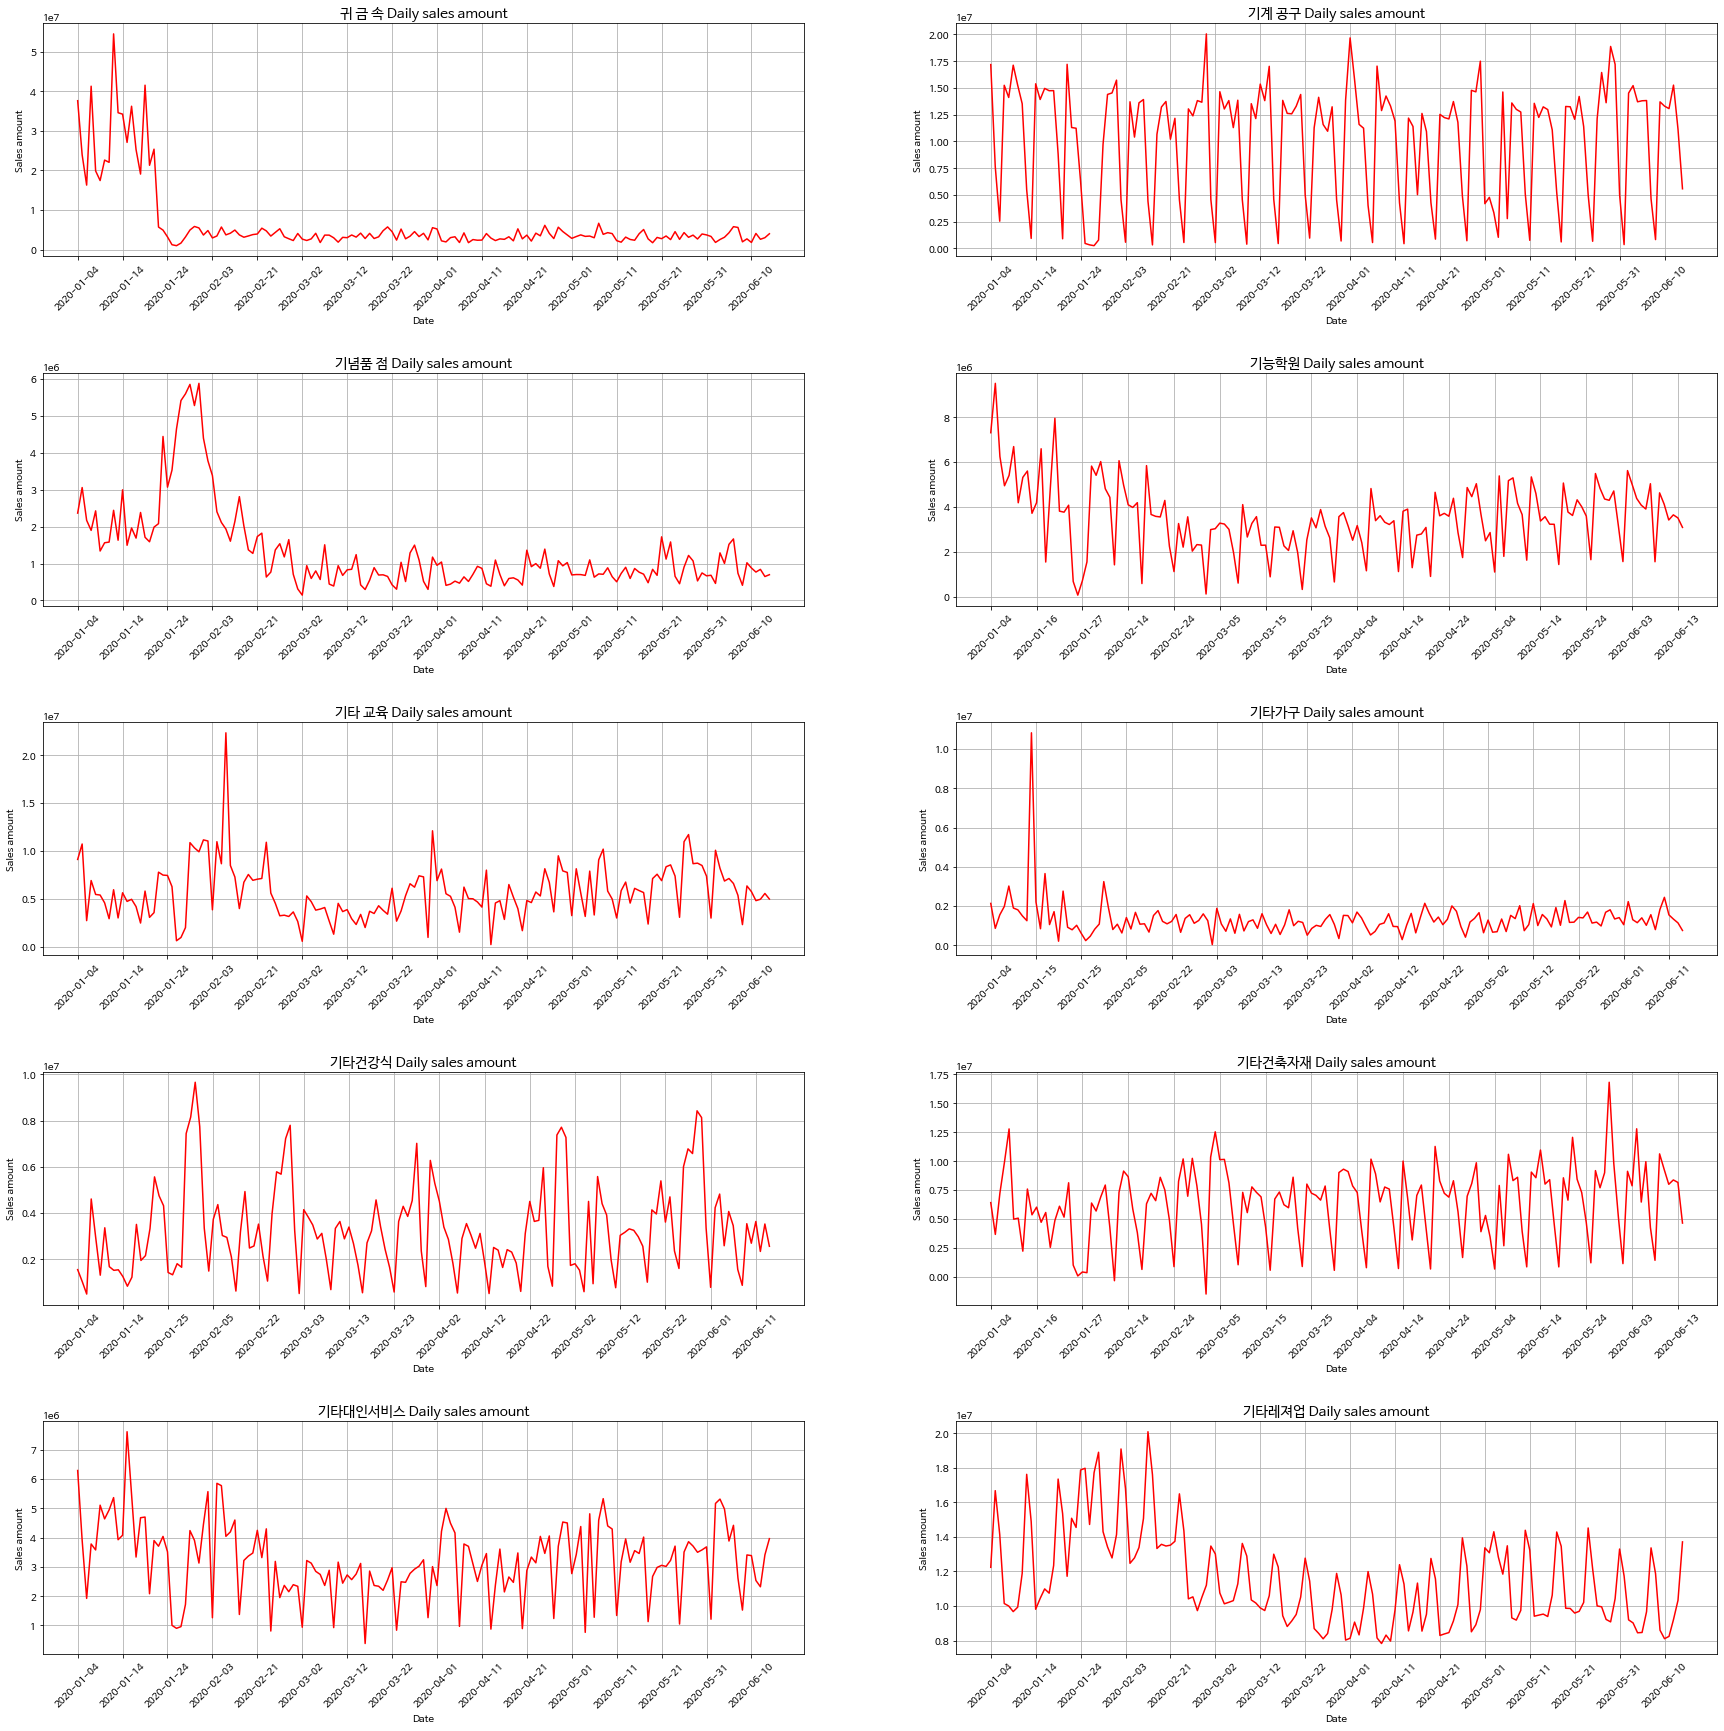

In [ ]:
fig = plt.figure(figsize=(30,30))
for n, indstry in zip(np.arange(1,11), indstry_list[11:21]):
  a = int(round(n/2))
  b = n%2
  indstry_df = indstry_group_card.query(f"mrhst_induty_cl_nm == '{indstry}'").sort_values('ymd').reset_index().iloc[:,1:]
  
  tem_x = indstry_df['ymd']
  tem_y = indstry_df['salamt']
  xn = len(tem_x)
  tem_range = np.arange(xn)
  
  ax = fig.add_subplot(5, 2, n)
  fig.subplots_adjust(hspace = .5)
  ax.plot(tem_range, tem_y, 'r-')
  plt.yticks(fontsize = 10)
  plt.xticks(tem_range, tem_x[::10], rotation = 45, fontsize = 10)
  plt.title('%s Daily sales amount'%(indstry) , fontsize = 14)
  plt.xlabel('Date', fontsize = 10)
  plt.ylabel('Sales amount', fontsize = 10)
  plt.locator_params(axis='x', nbins=xn/10)
  plt.grid()
plt.show()

- 코로나 확진자 발생 이후의 상황을 구분을 하자면 총 네 경우로 나눌 수 있습니다.
  - 코로나 이후에 총매출이 급감한 경우
  - 코로나 전후 총매출의 변동이 없거나 조금 상승한 경우
  - *주기성을 띠며* 코로나 이후에 총매출이 급감한 경우
  - *주기성을 띠며* 코로나 전후 총매출의 변동이 없거나 조금 상승한 경우

#### 품목별 CGI의 시계열 데이터
- **Dimension**
  - period  : 기준월
  - catl    : 대분류
  - catm    : 중분류 -> 17개
  - age     : 나이대
  - gender  : 성별
  - sido    : 지역
  - sigungu : 세부지역
- **Value**
  - cgi     : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)


In [ ]:
tem_idx = index.query("age == 'all' and gender == 'all' and period >= 202001").reset_index().iloc[:,1:]
catm_list = list(tem_idx['catm'].unique())
tem_idx['base_ym'] = pd.to_datetime(tem_idx['period'], format = '%Y%m').astype(str).str[:7]

##### 서울 2020년 월별 CGI
- 2019년을 예년과 비슷한 수준이라고 가정 하에 2020년의 데이터만 놓고 비교해봤습니다.
- 그리고 구별 전체적인 특성을 보기 위해서 나이대, 성별을 all로 놓고 cgi를 확인해봤습니다.
- 세분화 범주를 확인하기 위해 **중분류**, **시군구** 컬럼을 사용했습니다.

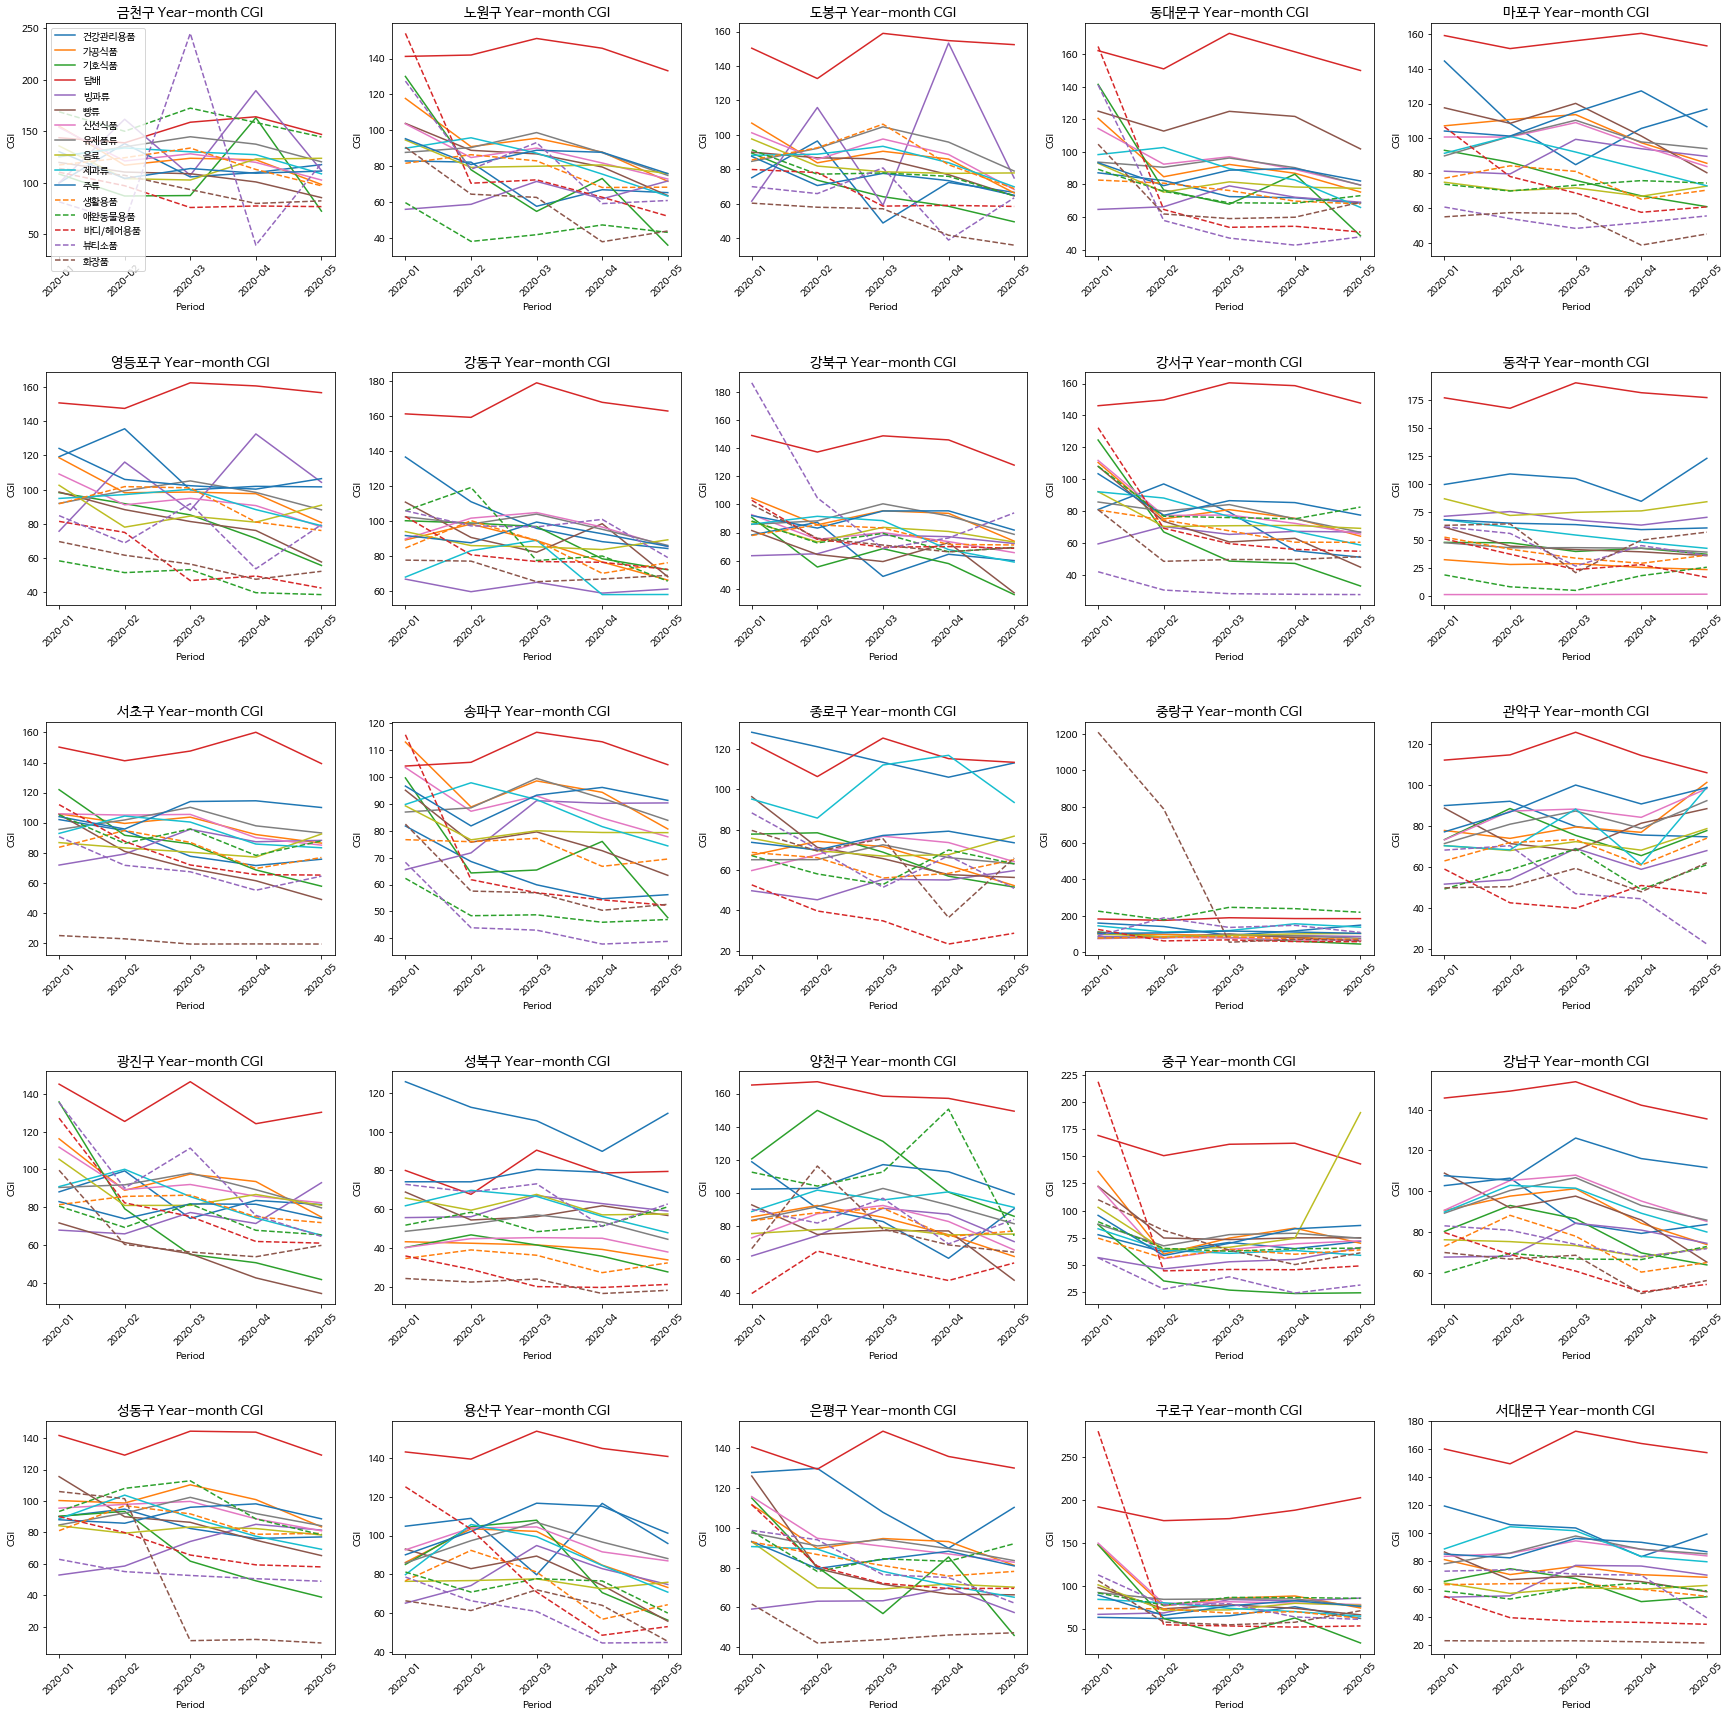

In [ ]:
fig = plt.figure(figsize=(30,30))
for n, sigungu in zip(np.arange(1,26), sigungu_list):
  a = int(round(n/5))
  b = n%5
  sigungu_df = tem_idx.query(f"sigungu == '{sigungu}'").sort_values('base_ym').reset_index().iloc[:,1:]
  tem_x = sigungu_df['base_ym'].unique()
  xn = len(tem_x)
  tem_range = np.arange(xn)
  
  ax = fig.add_subplot(5, 5, n)
  fig.subplots_adjust(hspace = .5)
  for cat_idx in range(len(catm_list)):
    catm = catm_list[cat_idx]
    tem_sigungu_df = sigungu_df.query(f"catm == '{catm}'").sort_values('base_ym').reset_index().iloc[:,1:]
    tem_y = tem_sigungu_df['cgi']
    try:
      if cat_idx <=10:
        ax.plot(tem_range, tem_y, label = catm, ls = '-')
      else:
        ax.plot(tem_range, tem_y, label = catm, ls = '--')
    except:
      continue
  plt.yticks(fontsize = 10)
  plt.xticks(tem_range, tem_x, rotation = 45, fontsize = 10)
  plt.title('%s Year-month CGI'%(sigungu) , fontsize = 14)
  plt.xlabel('Period', fontsize = 10)
  plt.ylabel('CGI', fontsize = 10)
  if n==1:
    plt.legend(loc = 'upper left')
    continue
plt.show()

- 확진자 급증이 제일 심했던 3월에 광진구, 성북구, 금천구 등에서 공통적으로 **뷰티소품**의 CGI 수치가 높아짐을 알 수 있습니다.
  - 이 점에 주목하여 앞으로의 분석이 진행될 것입니다.

## **03. 가설 설정**
저희는 분석을 위해 다음의 세 가지 간단한 가정을 설정하고 시작하였습니다.

<br>


**1) 서울의 구를 업무 중심 지역/주거 중심 지역으로 나눌 수 있다.**

- <국토의 계획 및 이용에 관한 법률 시행령(약칭: 국토계획법 시행령)>에 따르면, 도시는 주거지역/상업지역/공업지역/녹지지역으로 나뉘어 용도에 맞게 개발이 이루어집니다.
- http://kosis.kr/statHtml/statHtml.do?orgId=201&tblId=DT_201_00244 <br>
  실제로 위의 사이트를 통해 서울시의 용도지역 현황을 확인해볼 수 있습니다. 일례로 동대문구의 경우 '주거' 용도의 지역은 전체 용도 지역의 92%에 해당하지만, 강남구의 경우 '주거' 용도의 지역은 55% 정도에 그칩니다. 특히 강남구는 여러 회사가 밀집해있는 구인 만큼, 주거 용도보다는 업무 용도로 사용되는 토지의 비율이 더 높을 것입니다.
- 저희는 이러한 배경을 바탕으로 하여 서울 전체 구를 '업무 중심 지역(구)'과 '주거 중심 지역(구)'으로 그루핑한 후 분석을 진행하기로 하였습니다. 그렇다면 어떠한 feature를 기준으로 구를 나누어볼 수 있을까요?

<br>

**2) 업무 중심 지역일수록 유동 인구 연령 분산이 크다. 반면 주거 중심 지역일수록 인구 연령 분산이 작다.**
   - 가장 먼저 저희는 업무 중심 지역일수록 다양한 연령층의 유동인구가 유입될 것, 반대로 주거지역일수록 유동인구의 연령층이 다양하지 않을 것이라는 가정 하에 "유동인구 연령 분산"을 첫 번째 feature로 설정하였습니다. 
   - fpopl의 유동인구 연령 칼럼들을 사용하였습니다.

<br>

**3) 업무 중심 지역일수록 지역 총매출이 크다. 반면 주거 중심 지역일수록 지역 총매출이 작다.**
   - 두 번째로 업무지역일수록 청장년층의 유동인구가 많이 유입되어 지역의 총 매출액이 높을 것이라는 가정 하에 "지역 총매출"을 두 번째 feature로 설정하였습니다.
   - card의 saleamt 칼럼을 사용하였습니다.

<br>

아래는 2), 3)에 해당되는 feature를 추출하는 코드입니다.

### 유동인구 연령분산 & 총매출
- age_00 ~ age_70을 column-wise 시킨 pivoted table에서 **연령 비율**을 구한 뒤 분산을 구합니다.
- 이후에 일자별, 구별 총매출 테이블을 조인하여 수치를 도출합니다.

In [ ]:
pivot_sex_fpop.columns = ['base_ymd', 'sigungu_code']+pivot_sex_fpop.columns.to_list()[2:]
dim = ['base_ymd', 'sigungu_code']
pivot_age_fpop = pd.DataFrame(pivot_sex_fpop.groupby(dim).sum().to_records())
merge_age_fpop = pd.merge(pivot_age_fpop, astrd_master[['sigungu_code', 'signgu_nm']], how = 'left').drop_duplicates()
merge_age_fpop = merge_age_fpop.reset_index().iloc[:,1:]

- 유동 인구 연령 비율(%) 구하기

In [ ]:
merge_age_fpop['popl'] = merge_age_fpop.iloc[:,2:16].sum(axis=1)
for age in age_list:
  merge_age_fpop[age] = np.round(100*merge_age_fpop[age]/merge_age_fpop['popl'], 1)

- 연령 분산 구하기

In [ ]:
tem_var = list()
N = len(merge_age_fpop)
for k in range(N):
  tem_var.append(merge_age_fpop.iloc[k,2:16].var())
merge_age_fpop['age_var'] = tem_var

In [ ]:
merge_age_fpop.head(5)

,base_ymd,sigungu_code,age_00,age_10,age_15,age_20,age_25,age_30,age_35,age_40,age_45,age_50,age_55,age_60,age_65,age_70,signgu_nm,popl,age_var
0,20200101,1111,0.3,1.2,3.6,11.1,14.1,10.0,8.9,7.7,9.4,9.0,9.1,7.1,3.9,4.5,종로구,1289867,15.399396
1,20200101,1114,0.3,1.1,3.0,10.3,14.9,11.5,10.2,8.1,8.9,8.5,8.4,6.9,3.9,3.9,중구,1250912,17.499396
2,20200101,1117,0.3,1.3,3.3,10.2,15.1,12.1,10.7,8.3,8.9,8.5,7.9,6.2,3.4,3.7,용산구,2122425,18.400934
3,20200101,1120,0.4,1.5,3.6,9.3,13.1,11.4,11.0,8.6,9.3,9.0,8.6,6.7,3.6,4.0,성동구,1892216,15.228846
4,20200101,1121,0.3,1.3,4.5,11.8,14.5,10.7,9.6,7.7,8.5,8.8,8.5,6.7,3.5,3.6,광진구,1832597,16.554945


- 구별 평균값

In [ ]:
dim = ['signgu_nm']
grouped_sex_age = merge_age_fpop[dim+['age_var']].groupby(dim).mean()

- 구별 총매출(평균값) 테이블
  - 행정구별로 전체적인 특성을 보기 위해 시계열 데이터의 평균값을 사용

In [ ]:
dim = ['signgu_nm']
grouped_signgu_card = pd.DataFrame(merge_card.groupby(dim).sum().to_records()[dim+['salamt']])

- 구별 연령분산, 총매출 join 테이블

In [ ]:
merged_signgu_popl = pd.merge(grouped_sex_age, grouped_signgu_card, how = 'left', on ='signgu_nm')

- 두 feature의 범위가 다르기 때문에 표준화한 값을 통하여 시각화했습니다.

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(merged_signgu_popl[['age_var', 'salamt']])
pd_scaled = pd.DataFrame(scaled, columns = ['scaled_age_var', 'scaled_salamt'])
merged_signgu_popl = pd.concat((merged_signgu_popl, pd_scaled), axis = 1)

In [ ]:
tem_x = merged_signgu_popl['scaled_age_var']
tem_y = merged_signgu_popl['scaled_salamt']
signgu_nm = merged_signgu_popl['signgu_nm']

- 각 구별 "유동인구 연령 분산"과 "지역 총매출" 값을 구한 후, Scaled 값을 아래와 같이 그래프를 그려 확인해보았습니다.

In [ ]:
district = {'업무 중심 지역' : ['강남구', '서초구', '마포구', '중구', '용산구']
, '혼재 지역' : ['구로구', '종로구', '영등포구', '관악구', '강서구', '송파구', '서대문구', '성동구', '광진구', '동작구', '금천구']
, '주거 중심 지역' : ['강동구', '동대문구', '중랑구', '양천구', '성북구', '강북구', '노원구', '은평구', '도봉구']}
cluster = list()
for k in merged_signgu_popl['signgu_nm']:
  if k in district['업무 중심 지역']:
    cluster.append('업무 중심 지역')
  elif k in district['주거 중심 지역']:
    cluster.append('주거 중심 지역')
  else:
    cluster.append('혼재 지역')
merged_signgu_popl['cluster'] = cluster

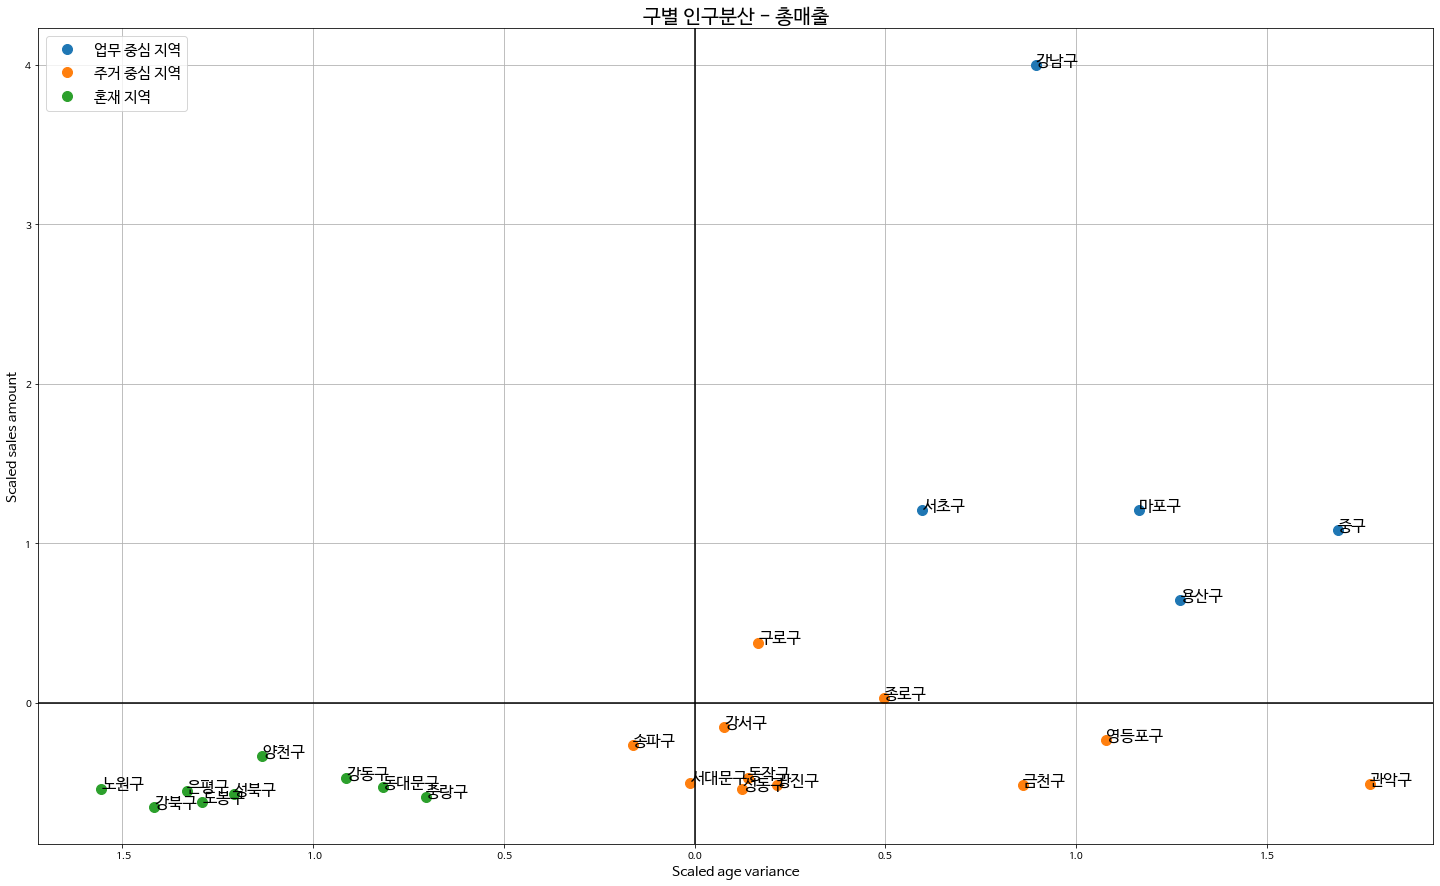

In [ ]:
plt.figure(figsize=(25,15))
for name, group in merged_signgu_popl.groupby('cluster'):
  plt.plot(group.scaled_age_var, group.scaled_salamt
           , marker='o'
           , linestyle=''
           , label=name
           , markersize = 10)
for i, txt in enumerate(signgu_nm):
    plt.annotate(txt, (tem_x[i], tem_y[i]), fontsize = 16)
plt.title('구별 인구분산 - 총매출', fontsize=20)
plt.xlabel('Scaled age variance', fontsize=14)
plt.ylabel('Scaled sales amount', fontsize=14)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

- 위의 시각화 결과를 통해 다음와 같이 서울의 구들을 나누어볼 수 있습니다.
  - **업무 중심 지역(구)** : 강남구, 서초구, 마포구, 중구, 용산구
  - **주거 중심 지역(구)** : 강동구, 동대문구, 중랑구, 양천구, 성북구, 강북구, 노원구, 은평구, 도봉구
  - **업무와 주거가 혼재된 지역(구)** : 구로구, 종로구, 영등포구, 관악구, 강서구, 송파구, 서대문구, 성동구, 구진구, 동작구, 금천구
- 어떠한 한 지역의 특징을 기술하기 위해서는 '인구 연령 분산'과 '매출 총합' 외에도 수많은 feature들이 사용될 수 있을 것입니다. 그럼에도 불구하고 위의 그래프를 확인한 결과, 업무/주거지역을 나누는 데에는 저희가 사용한 두 가지 차원만으로도 충분함을 알 수 있습니다. grouping 결과는 실제 서울의 각 구에 특징에 대해 일반적으로 알려진 바와도 잘 부합합니다.

<br>

## **04. 심화 분석 : 구의 특징에 따른 소비 패턴 변화는?**



#### 전체 행정구별 직종 - 확진자 상관관계
- 본격적으로 심화 분석을 진행하기에 앞서, 전체적으로 코로나 확진자 수와 업종별 매출의 상관관계를 살펴보도록 하겠습니다.

In [ ]:
signgu_corona.columns = signgu_corona.columns.to_list()[:2]+['confirmed_cnt']

- 시계열 총매출 - 확진자 추이 데이터 상관관계 구하기

In [ ]:
corr_df = list()
scaler = StandardScaler()

tem_corona = pd.DataFrame(signgu_corona.groupby('confirmed_date').sum().to_records())[['confirmed_date','confirmed_cnt']].reset_index().iloc[:,1:]
tem_corona['base_ymd'] = tem_corona['confirmed_date'].astype(str).str[:4]+tem_corona['confirmed_date'].astype(str).str[5:7] \
          + tem_corona['confirmed_date'].astype(str).str[8:]
tem_grouped_card = group_card.reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
## 직종 column-wise
tem_pivot = tem_grouped_card.pivot_table(index=['base_ymd'], columns='mrhst_induty_cl_nm', 
                                values='salamt', aggfunc= 'sum')
final_pd = pd.DataFrame(tem_pivot.to_records()).fillna(0)
final_pd['base_ymd'] = final_pd['base_ymd'].astype(str)
## 코로나 데이터 left join
merge_pd = pd.merge(final_pd, tem_corona, how = 'left', on = 'base_ymd')
merge_pd = merge_pd.drop(['base_ymd','confirmed_date'], axis = 1).fillna(0)
## 직종-코로나 상관관계 
tem_pd = pd.DataFrame(np.array([merge_pd.corr().index.to_list(), np.round(merge_pd.corr()['confirmed_cnt'], 3)]).T, columns = ['indstry_nm', 'corr'])
tem_pd['corr'] = tem_pd['corr'].astype(float)
sorted_pd = tem_pd.sort_values('corr', ascending=False).reset_index().iloc[:,1:]
temidx = list(sorted_pd['indstry_nm']).index('confirmed_cnt')
sorted_pd = sorted_pd.iloc[temidx+1:,:].dropna()

- 총매출 - 확진자 추이 데이터 상관관계 시각화

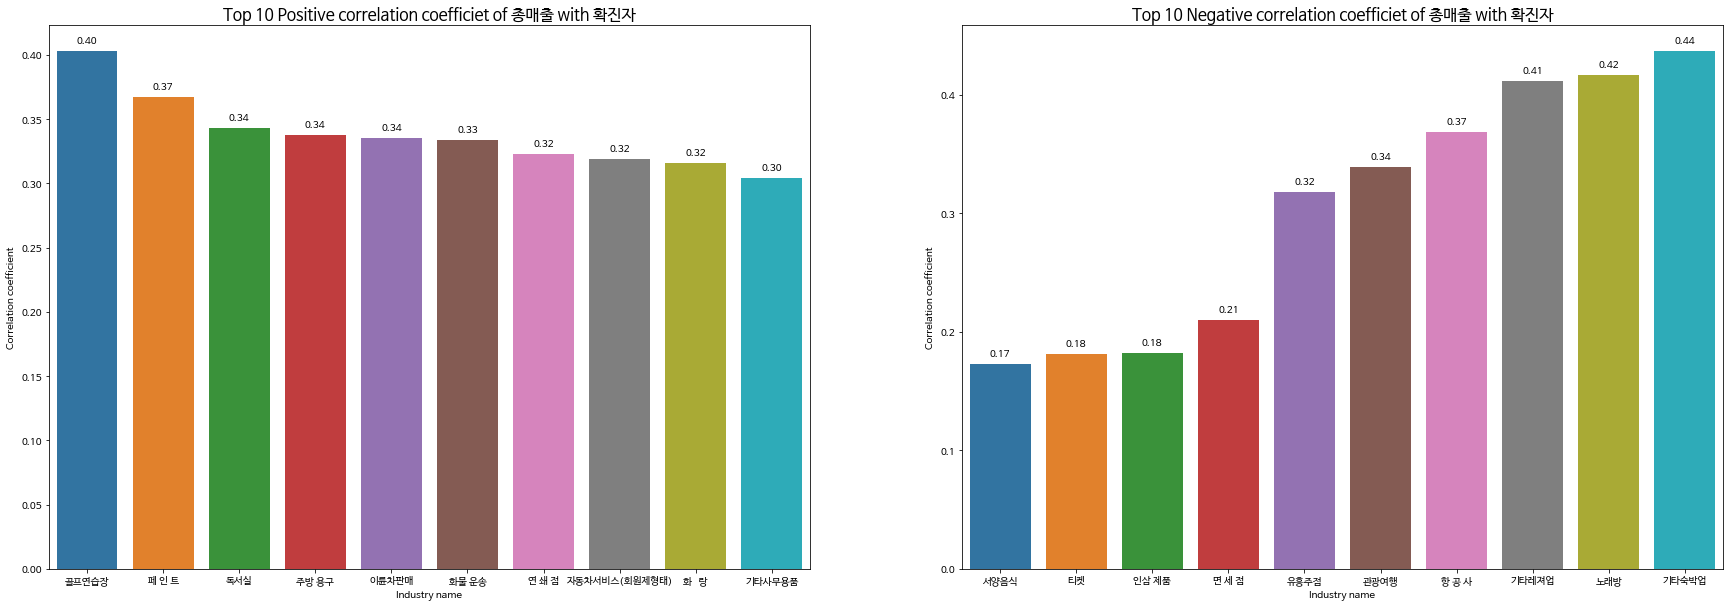

In [ ]:
sorted_pd['corr'] = np.abs(sorted_pd['corr'])
fig, axes = plt.subplots(1,2, figsize = (30,10))
for i, axe in enumerate(axes):
  if i==0:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[:10,:], ax = axe)
    axe.set_title("Top 10 Positive correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  else:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[-10:,:], ax = axe)
    axe.set_title("Top 10 Negative correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  for p in axe.patches:
    axe.annotate(format(p.get_height(), '.2f')
    , (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center'
    , xytext = (0, 10), textcoords = 'offset points')
  axe.set_xlabel('Industry name')
  axe.set_ylabel('Correlation coefficient')

- 총매출과 확진자 현황의 전체적인 상관관계를 양의 상관관계, 음의 상관관계 Top10을 시각화했습니다.
  - 양의 상관관계 Top 10 : 골프연습장, 페인트, 독서실 ...
  - 음의 상관관계 Top 10 : 기타숙박업, 노래방, 기타레저업 ...
 
<br>

- 음의 상관관계의 품목들은 코로나로 인해 타격을 입었을 것으로 예상이 가능한 종목들입니다. 여행이나 유흥 관련 품목들과 외식 산업 관련 종목들이 총매출이 가장 많이 감소한 것으로 분석됩니다.
- 양의 상관관계의 품목들은 큰 공통점이 없어 보이지만, 대체로 야외에서 사람들이 밀집해 있지 않는 곳에서의 활동이 줄어들면서 사람들이 관심을 갖거나 활동이 일어나는 품목들이라고 볼 수 있습니다. ex) 골프 연습장, 독서실
- 다만 EDA 과정에서 CGI 지수 관련하여 **특정 지역에서 뷰티 제품의 항목이 늘어난 현상**과 같이, 행정구별 현황에 대해서 알아보기 위해 디멘션을 더 늘려 상관관계를 확인해봅니다.

#### 지역 분류별 직종 - 확진자 상관관계
- 앞서 **업무 중심 지역, 주거 중심 지역, 혼재 지역**으로 구분을 했기 때문에, 세 가지로 분류하여 상관관계를 살펴보겠습니다.

##### **업무 중심 지역**
- 강남구, 서초구, 마포구, 중구, 용산구

In [ ]:
tem_grouped_card = list()
for sign in district['업무 중심 지역']:
  if sign == district['업무 중심 지역'][0]:
    tem_grouped_card = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
  else:
    tem_card_df = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
    tem_grouped_card = pd.concat((tem_grouped_card, tem_card_df), axis = 0)

In [ ]:
corr_df = list()
scaler = StandardScaler()

tem_grouped_card = tem_grouped_card.reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
## 직종 column-wise
tem_pivot = tem_grouped_card.pivot_table(index=['base_ymd'], columns='mrhst_induty_cl_nm', 
                                values='salamt', aggfunc= 'mean')
final_pd = pd.DataFrame(tem_pivot.to_records()).fillna(0)
final_pd['base_ymd'] = final_pd['base_ymd'].astype(str)
## 코로나 데이터 left join
merge_pd = pd.merge(final_pd, tem_corona, how = 'left', on = 'base_ymd')
merge_pd = merge_pd.drop(['base_ymd','confirmed_date'], axis = 1).fillna(0)
## 직종-코로나 상관관계 
tem_pd = pd.DataFrame(np.array([merge_pd.corr().index.to_list(), np.round(merge_pd.corr()['confirmed_cnt'], 3)]).T, columns = ['indstry_nm', 'corr'])
tem_pd['corr'] = tem_pd['corr'].astype(float)
sorted_pd = tem_pd.sort_values('corr', ascending=False).reset_index().iloc[:,1:]
temidx = list(sorted_pd['indstry_nm']).index('confirmed_cnt')
sorted_pd = sorted_pd.iloc[temidx+1:,:].dropna()

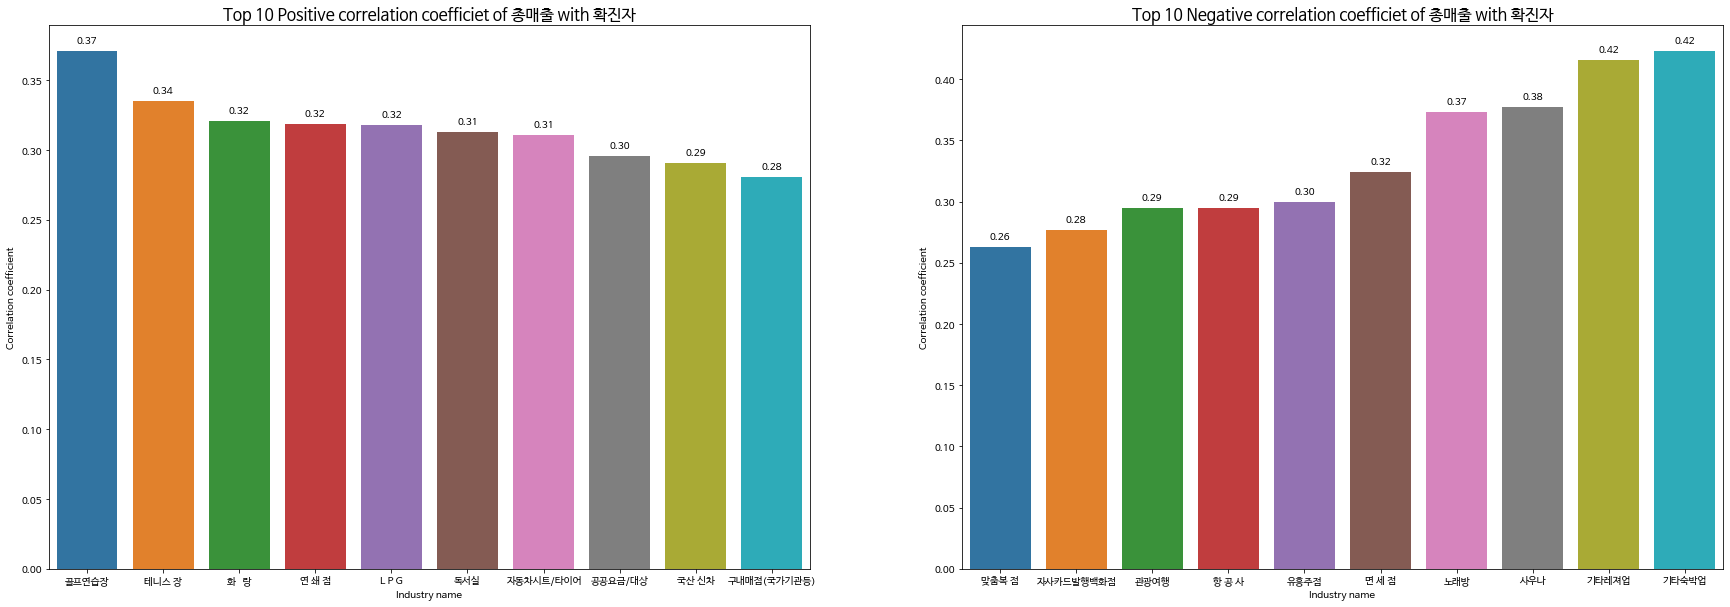

In [ ]:
sorted_pd['corr'] = np.abs(sorted_pd['corr'])
fig, axes = plt.subplots(1,2, figsize = (30,10))
for i, axe in enumerate(axes):
  if i==0:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[:10,:], ax = axe)
    axe.set_title("Top 10 Positive correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  else:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[-10:,:], ax = axe)
    axe.set_title("Top 10 Negative correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  for p in axe.patches:
    axe.annotate(format(p.get_height(), '.2f')
    , (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center'
    , xytext = (0, 10), textcoords = 'offset points')
  axe.set_xlabel('Industry name')
  axe.set_ylabel('Correlation coefficient')

##### **주거 중심 지역**
- 강동구, 동대문구, 중랑구, 양천구, 성북구, 강북구, 노원구, 은평구, 도봉구



In [ ]:
tem_grouped_card = list()
for sign in district['주거 중심 지역']:
  if sign == district['주거 중심 지역'][0]:
    tem_grouped_card = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
  else:
    tem_card_df = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
    tem_grouped_card = pd.concat((tem_grouped_card, tem_card_df), axis = 0)

In [ ]:
corr_df = list()
scaler = StandardScaler()

tem_grouped_card = tem_grouped_card.reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
## 직종 column-wise
tem_pivot = tem_grouped_card.pivot_table(index=['base_ymd'], columns='mrhst_induty_cl_nm', 
                                values='salamt', aggfunc= 'mean')
final_pd = pd.DataFrame(tem_pivot.to_records()).fillna(0)
final_pd['base_ymd'] = final_pd['base_ymd'].astype(str)
## 코로나 데이터 left join
merge_pd = pd.merge(final_pd, tem_corona, how = 'left', on = 'base_ymd')
merge_pd = merge_pd.drop(['base_ymd','confirmed_date'], axis = 1).fillna(0)
## 직종-코로나 상관관계 
tem_pd = pd.DataFrame(np.array([merge_pd.corr().index.to_list(), np.round(merge_pd.corr()['confirmed_cnt'], 3)]).T, columns = ['indstry_nm', 'corr'])
tem_pd['corr'] = tem_pd['corr'].astype(float)
sorted_pd = tem_pd.sort_values('corr', ascending=False).reset_index().iloc[:,1:]
temidx = list(sorted_pd['indstry_nm']).index('confirmed_cnt')
sorted_pd = sorted_pd.iloc[temidx+1:,:].dropna()

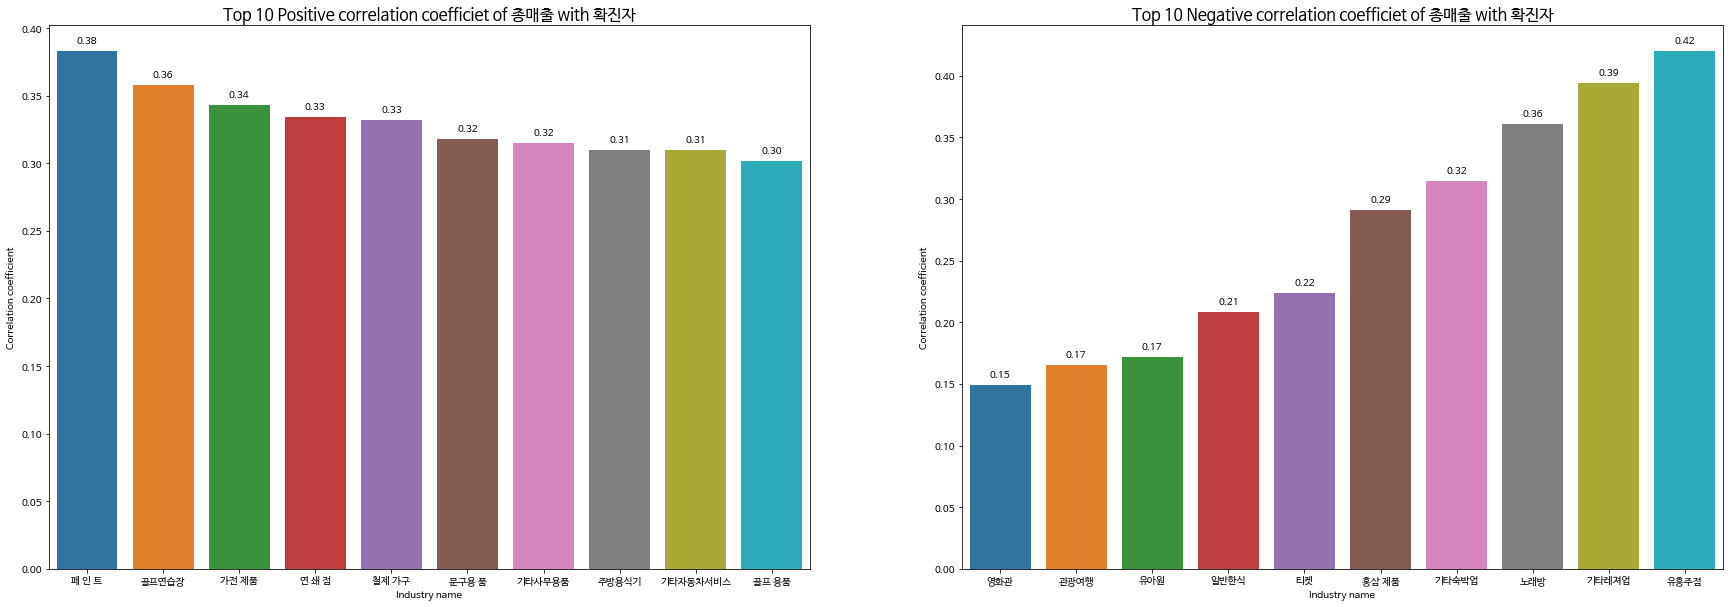

In [ ]:
sorted_pd['corr'] = np.abs(sorted_pd['corr'])
fig, axes = plt.subplots(1,2, figsize = (30,10))
for i, axe in enumerate(axes):
  if i==0:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[:10,:], ax = axe)
    axe.set_title("Top 10 Positive correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  else:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[-10:,:], ax = axe)
    axe.set_title("Top 10 Negative correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  for p in axe.patches:
    axe.annotate(format(p.get_height(), '.2f')
    , (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center'
    , xytext = (0, 10), textcoords = 'offset points')
  axe.set_xlabel('Industry name')
  axe.set_ylabel('Correlation coefficient')

##### **주거 업무 혼재 지역**
- 구로구, 종로구, 영등포구, 관악구, 강서구, 송파구, 서대문구, 성동구, 구진구, 동작구, 금천구



In [ ]:
tem_grouped_card = list()
for sign in district['혼재 지역']:
  if sign == district['혼재 지역'][0]:
    tem_grouped_card = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
  else:
    tem_card_df = merge_card.query(f"signgu_nm == '{sign}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
    tem_grouped_card = pd.concat((tem_grouped_card, tem_card_df), axis = 0)

In [ ]:
corr_df = list()
scaler = StandardScaler()

tem_grouped_card = tem_grouped_card.reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]
## 직종 column-wise
tem_pivot = tem_grouped_card.pivot_table(index=['base_ymd'], columns='mrhst_induty_cl_nm', 
                                values='salamt', aggfunc= 'mean')
final_pd = pd.DataFrame(tem_pivot.to_records()).fillna(0)
final_pd['base_ymd'] = final_pd['base_ymd'].astype(str)
## 코로나 데이터 left join
merge_pd = pd.merge(final_pd, tem_corona, how = 'left', on = 'base_ymd')
merge_pd = merge_pd.drop(['base_ymd','confirmed_date'], axis = 1).fillna(0)
## 직종-코로나 상관관계 
tem_pd = pd.DataFrame(np.array([merge_pd.corr().index.to_list(), np.round(merge_pd.corr()['confirmed_cnt'], 3)]).T, columns = ['indstry_nm', 'corr'])
tem_pd['corr'] = tem_pd['corr'].astype(float)
sorted_pd = tem_pd.sort_values('corr', ascending=False).reset_index().iloc[:,1:]
temidx = list(sorted_pd['indstry_nm']).index('confirmed_cnt')
sorted_pd = sorted_pd.iloc[temidx+1:,:].dropna()

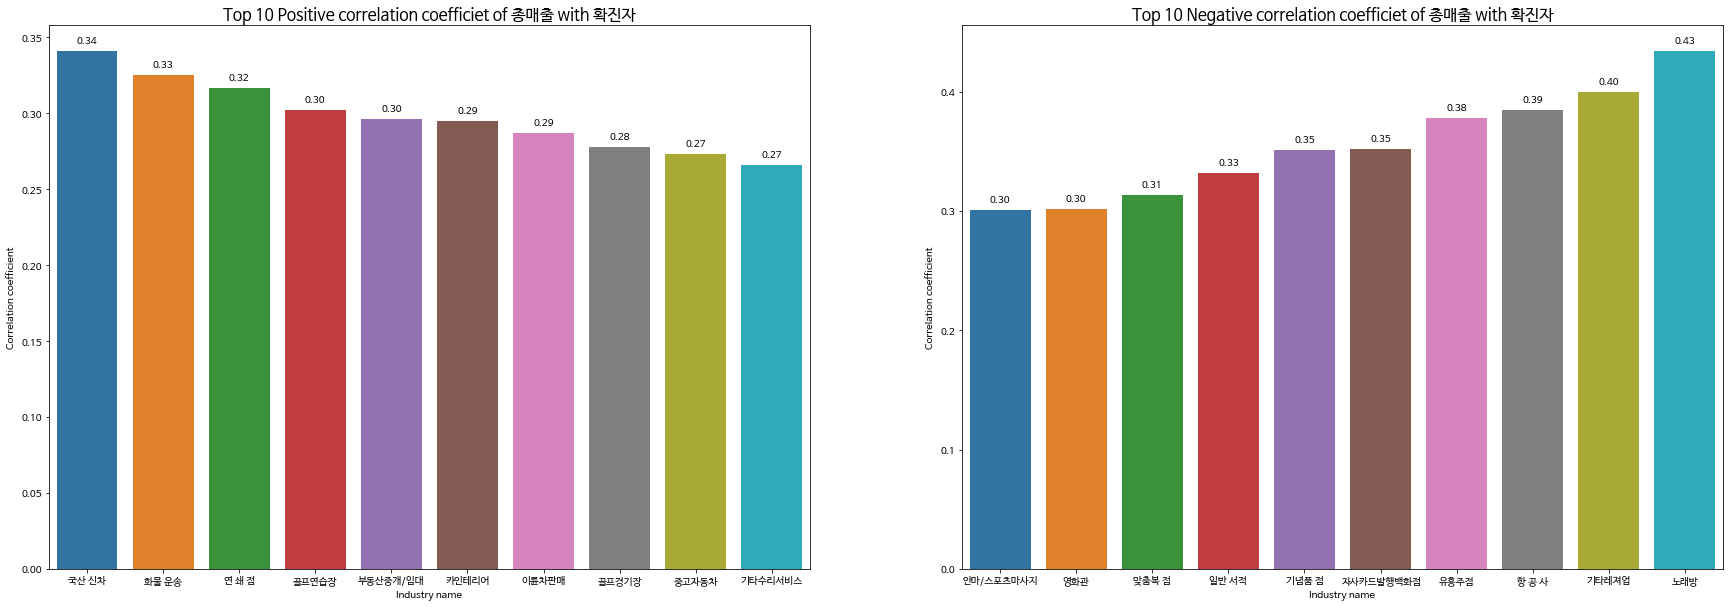

In [ ]:
sorted_pd['corr'] = np.abs(sorted_pd['corr'])
fig, axes = plt.subplots(1,2, figsize = (30,10))
for i, axe in enumerate(axes):
  if i==0:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[:10,:], ax = axe)
    axe.set_title("Top 10 Positive correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  else:
    sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[-10:,:], ax = axe)
    axe.set_title("Top 10 Negative correlation coefficiet of 총매출 with 확진자", fontsize = 16)
  for p in axe.patches:
    axe.annotate(format(p.get_height(), '.2f')
    , (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center'
    , xytext = (0, 10), textcoords = 'offset points')
  axe.set_xlabel('Industry name')
  axe.set_ylabel('Correlation coefficient')

##### **행정구별 상관관계 Top 10**

- 행정구별 총매출 - 확진자 추이 상관관계 구하기

In [ ]:
corr_dict = dict()
for sigungu in sigungu_list:
  tem_grouped_card = merge_card.query(f"signgu_nm == '{sigungu}'").reset_index().iloc[:,1:][['base_ymd','mrhst_induty_cl_nm','salamt']]

  ## 직종 column-wise
  tem_pivot = tem_grouped_card.pivot_table(index=['base_ymd'], columns='mrhst_induty_cl_nm', 
                                  values='salamt', aggfunc= 'mean')
  final_pd = pd.DataFrame(tem_pivot.to_records()).fillna(0)
  final_pd['base_ymd'] = final_pd['base_ymd'].astype(str)
  ## 코로나 데이터 left join
  merge_pd = pd.merge(final_pd, tem_corona, how = 'left', on = 'base_ymd')
  merge_pd = merge_pd.drop(['base_ymd','confirmed_date'], axis = 1).fillna(0)
  ## 직종-코로나 상관관계 
  tem_pd = pd.DataFrame(np.array([merge_pd.corr().index.to_list(), np.round(merge_pd.corr()['confirmed_cnt'], 3)]).T, columns = ['indstry_nm', 'corr'])
  tem_pd['corr'] = tem_pd['corr'].astype(float)
  sorted_pd = tem_pd.sort_values('corr', ascending=False).reset_index().iloc[:,1:]
  temidx = list(sorted_pd['indstry_nm']).index('confirmed_cnt')
  sorted_pd = sorted_pd.iloc[temidx+1:,:].dropna()
  corr_dict[sigungu] = sorted_pd

- 양의 상관관계 Top 10

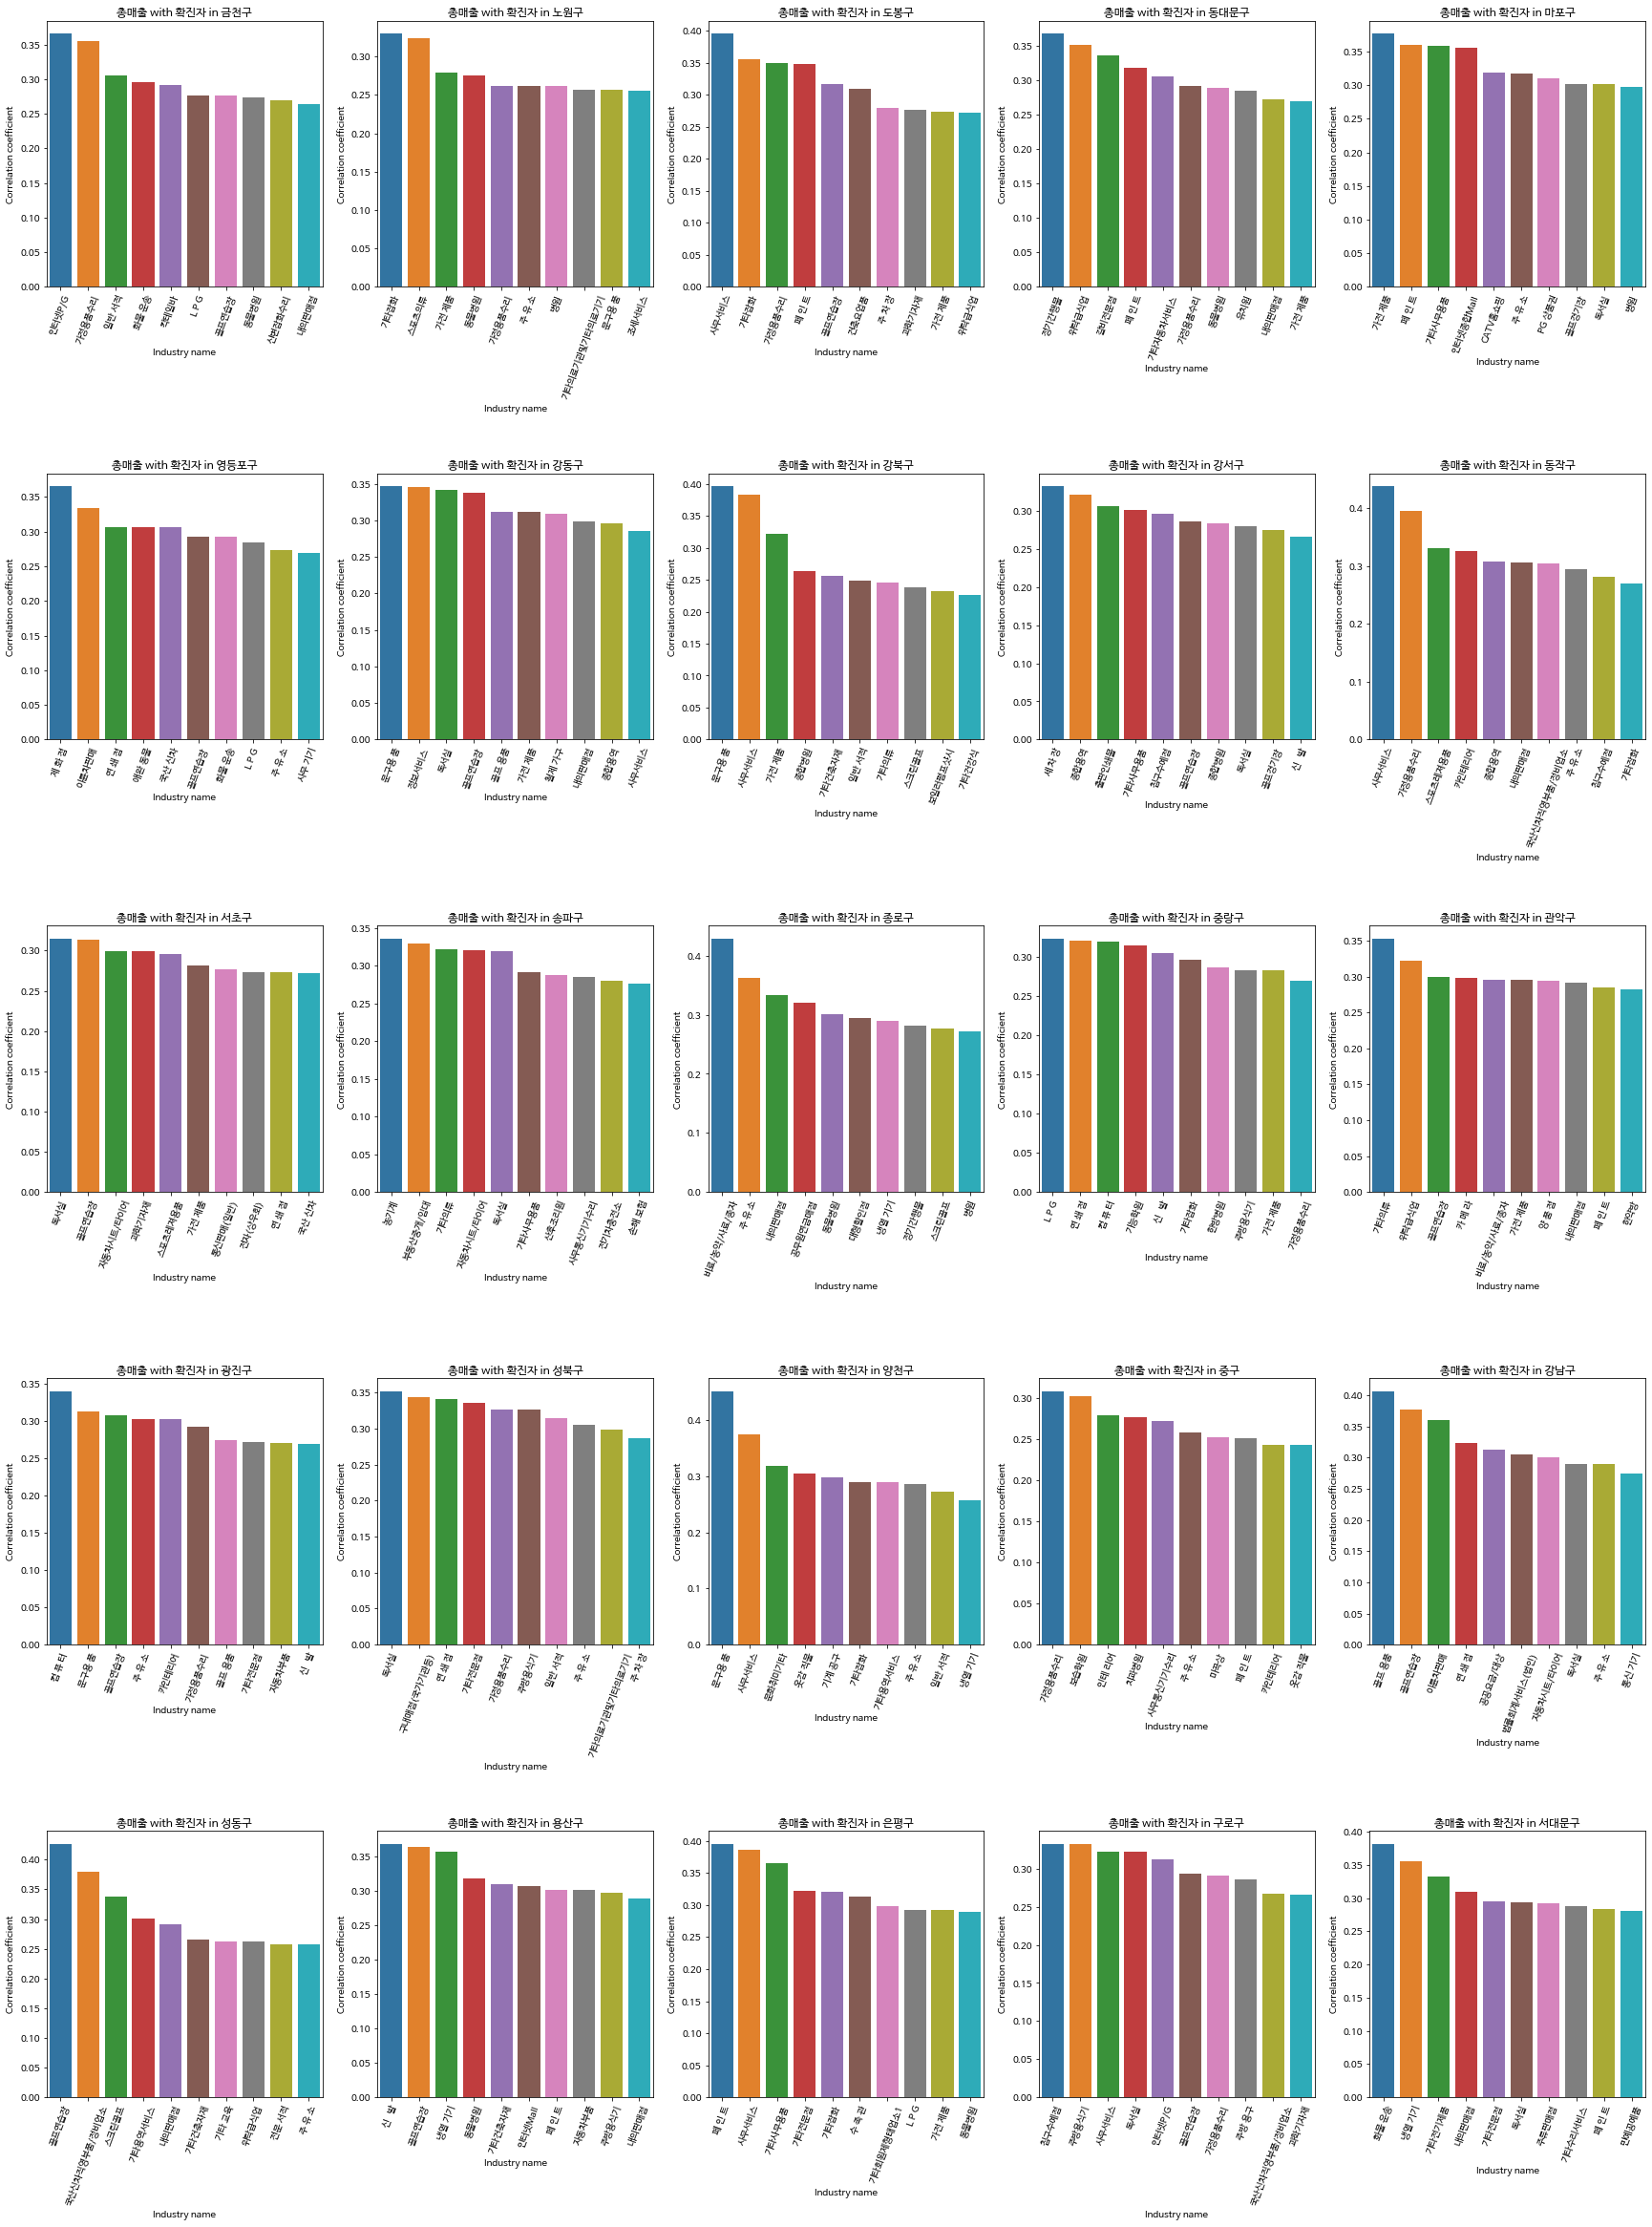

In [ ]:
fig = plt.figure(figsize=(30,40))
for n, sigungu in zip(np.arange(1,26), sigungu_list):
  a = int(round(n/5))
  b = n%5
  sorted_pd = corr_dict[sigungu]
  
  ax = fig.add_subplot(5, 5, n)
  fig.subplots_adjust(hspace = .7)
  sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[:10,:])
  ax.set_title("총매출 with 확진자 in %s"%(sigungu), fontsize = 12) 
  ax.set_xlabel('Industry name')
  ax.set_ylabel('Correlation coefficient')
  plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

plt.show()

- 음의 상관관계 Top 10

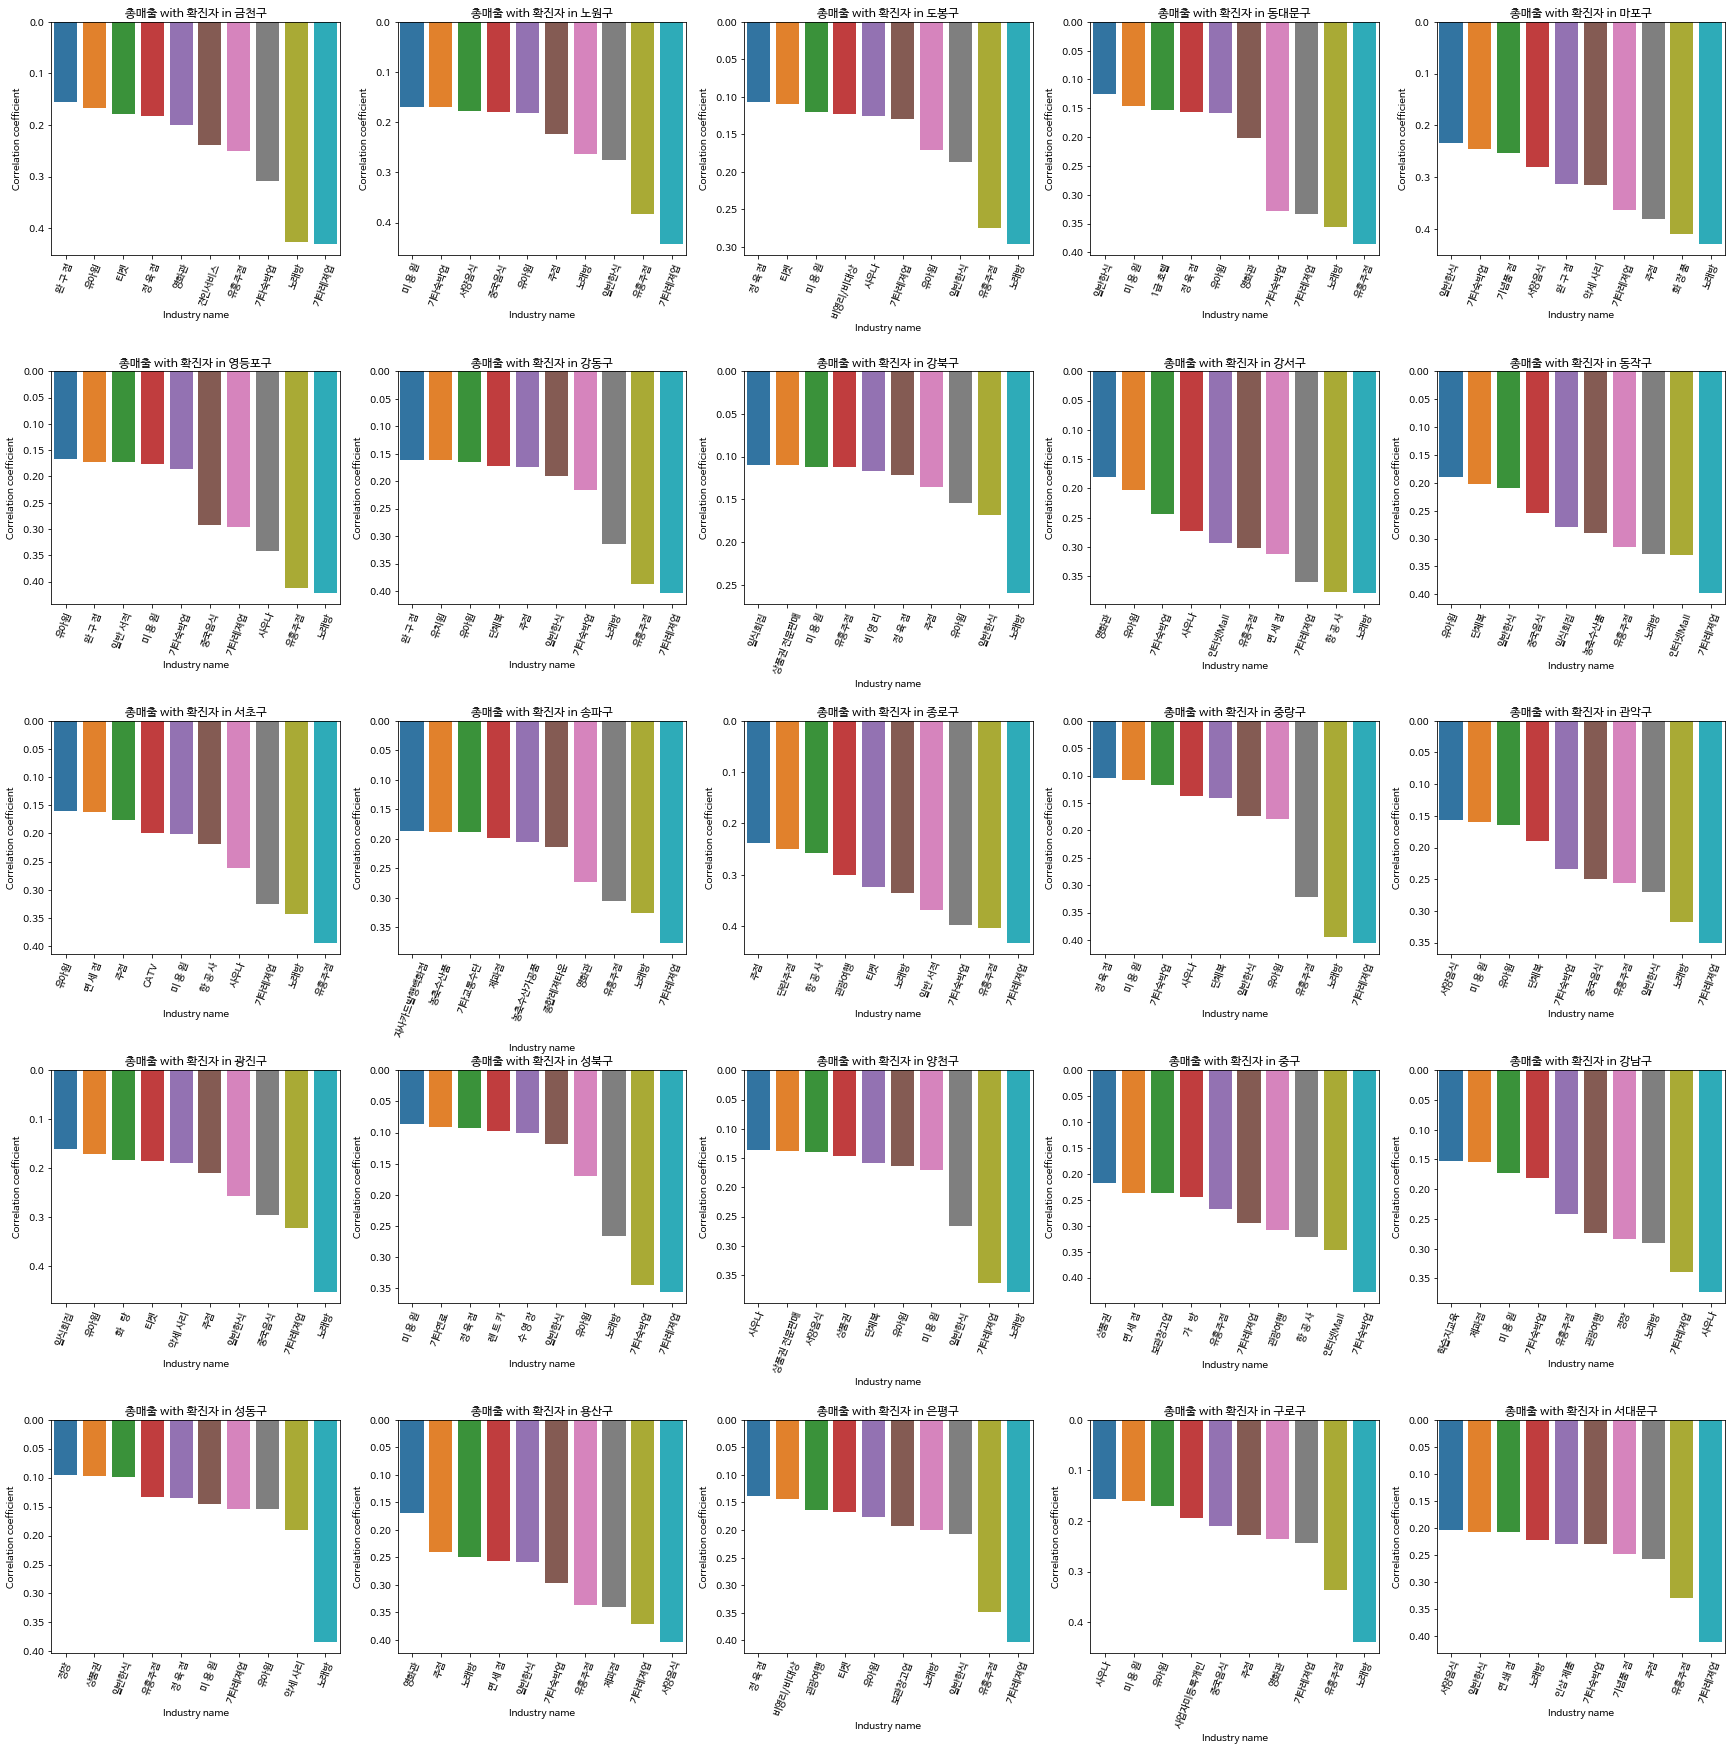

In [ ]:
fig = plt.figure(figsize=(30,30))
for n, sigungu in zip(np.arange(1,26), sigungu_list):
  a = int(round(n/5))
  b = n%5
  sorted_pd = corr_dict[sigungu]
  ax = fig.add_subplot(5, 5, n)
  fig.subplots_adjust(hspace = .5)
  sns.barplot(x= 'indstry_nm', y = 'corr', data = sorted_pd.iloc[-10:,:])
  ax.set_title("총매출 with 확진자 in %s"%(sigungu), fontsize = 12) 
  ax.set_xlabel('Industry name')
  ax.set_ylabel('Correlation coefficient')
  plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

plt.show()

## **05. 결론**
<br>

### 유동인구 연령 분산, 총매출을 통한 지역 분류

 위와 같은 방법으로 업무 중심 지역/주거 중심 지역을 나누어 진행된 소비 패텬 변화 분석 결과는, 단순히 "서울" 내에서 한정되지 않고 해당 특징을 갖는 세계 여러 도시들에 또한 적용될 수 있을 것입니다. 즉 서울이 아니더라도 "일반적으로 업무 중심 지역에서는 어떠한 소비 패텬의 변화가 일어난 반면, 주거 중심 지역에서는 다른 변화가 나타났다."는 해석이 가능해집니다.

 <br>

### 확진자 추이와 총매출의 변화의 상관성 분석
- 행정구별 상관관계를 시각화해 본 결과, 주거 지역(강동구, 동대문구, 중랑구, 양천구, 성북구, 강북구, 노원구, 은평구, 도봉구)의 음의 상관관계 Top10에 공통적으로 **미용원**이 들어갔습니다.
- 하지만 앞서 살펴본 CGI를 보면, 동 지역에서 코로나 확진자가 급증할 시기에 화장품 관련 CGI는 감소하거나 변화가 없지만, **뷰티 제품** 확연히 늘어난 것을 확인할 수 있었습니다.
<br>
- 코로나가 창궐하면서 화장품이나 뷰티 산업은 침체기를 맞았지만, 집에서 셀프로 할 수 있는 **셀프 케어(뷰티 케어 포함)** 관련 업종은 전망이 좋다고 볼 수 있습니다. (출처: https://news.kotra.or.kr/user/globalBbs/kotranews/782/globalBbsDataView.do?setIdx=243&dataIdx=181690)

